In [154]:
import numpy as np
import pandas as pd
import requests as req
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from scipy import stats
import re
import matplotlib
from sklearn.cluster import KMeans
from pathlib import Path
import os.path
from os import path
import urllib.request
import contextlib
from scipy.stats import kurtosis, skew

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Preprocessing
- <font size="3">load and select relevant data</font>
- <font size="3">clean data</font> 

In [155]:
f1 = 'US_CDI.csv'  # US Chronic Disease Indicators
f2 = 'US_LCD.csv'  # US Leading Causes of Death

#download dataset csv files if the files arent in the current directory
if not path.exists(f1):
    url = 'https://chronicdata.cdc.gov/views/g4ie-h725/rows.csv?accessType=DOWNLOAD'
    urllib.request.urlretrieve(url, f1)
    print("US_CDI.csv has been downloaded into current directory")
    
if not path.exists(f2):
    url = 'https://data.cdc.gov/api/views/bi63-dtpu/rows.csv?accessType=DOWNLOAD'
    urllib.request.urlretrieve(url, f2)
    print("US_LCD.csv has been downloaded into current directory")

cdiData = open(f1, 'r')
lcdData = open(f2, 'r')
cdi_df = pd.read_csv(cdiData)
lcd_df = pd.read_csv(lcdData)
cdiData.close()
lcdData.close()

#preprocessing

#dropping empty columns
#might need to automate this to check for empty columns, but it should be ok for now since datasets are known
to_drop = ['StratificationCategoryID2', 'StratificationID2', 'StratificationCategoryID3', 'StratificationID3',
          'StratificationCategory2', 'Stratification2', 'StratificationCategory3', 'Stratification3',
          'Response']
cdi_df.drop(to_drop, inplace=True, axis=1)

#convert some column datatypes to appropirate type
cdi_df['DataValue'] = pd.to_numeric(cdi_df['DataValue'], errors='coerce')
cdi_df['DataValueAlt'] = pd.to_numeric(cdi_df['DataValueAlt'], errors='coerce')

#change blank values of numeric columns to the mean of the column
#to prevent blank, NaN, and zero values from throwing off analysis
cdi_df['DataValue'] = cdi_df['DataValue'].fillna(cdi_df['DataValue'].mean())
cdi_df['DataValueAlt'] = cdi_df['DataValueAlt'].fillna(cdi_df['DataValueAlt'].mean())
cdi_df['LowConfidenceLimit'] = cdi_df['LowConfidenceLimit'].fillna(cdi_df['LowConfidenceLimit'].mean())
cdi_df['HighConfidenceLimit'] = cdi_df['HighConfidenceLimit'].fillna(cdi_df['HighConfidenceLimit'].mean())

#this is the code to dl the CSVs from the site directly
#but the files are pretty large, so might not wnat to do that
#url = 'https://chronicdata.cdc.gov/views/g4ie-h725/rows.csv?accessType=DOWNLOAD'
#cr = pd.read_csv(url), also need to specify dtype for some columns on this part

In [156]:
# display(lcd_df)
lcd_df.head()

,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alabama,2755,55.5
1,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alaska,439,63.1
2,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arizona,4010,54.2
3,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arkansas,1604,51.8
4,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,California,13213,32.0


## Analysis
- <font size="3">Exploratory Data Analysis</font>

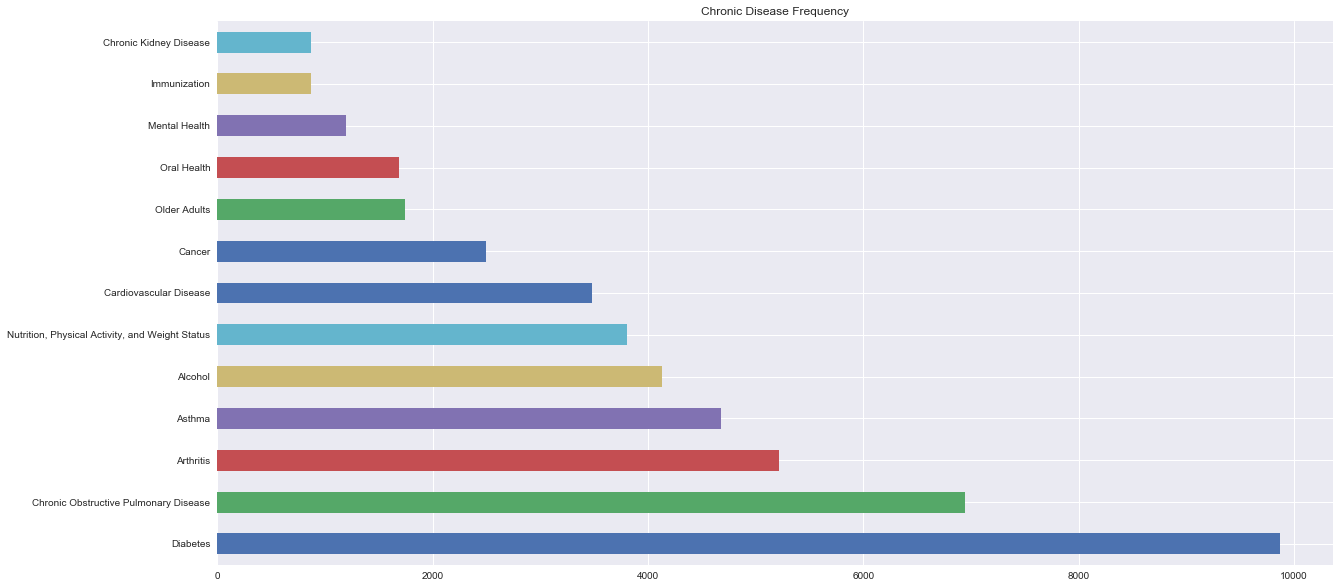

In [157]:
#This graph shows which chronic disease appear most in the histogram
pd.value_counts(cdi_df['Topic']).plot(kind='barh',figsize=(20,10), title='Chronic Disease Frequency')

Overall Disease Indicator Scores for the United States


,Location,Topic,DataValue
0,United States,Alcohol,9.710000
4134,United States,Arthritis,35.866667
9370,United States,Asthma,45.827273
14054,United States,Cancer,75.657143
16538,United States,Chronic Obstructive Pulmonary Disease,33.891667
23427,United States,Cardiovascular Disease,56.762500
27913,United States,Diabetes,45.006667
36924,United States,Immunization,38.700000
37793,United States,Mental Health,7.733333
38984,United States,Chronic Kidney Disease,2.750000


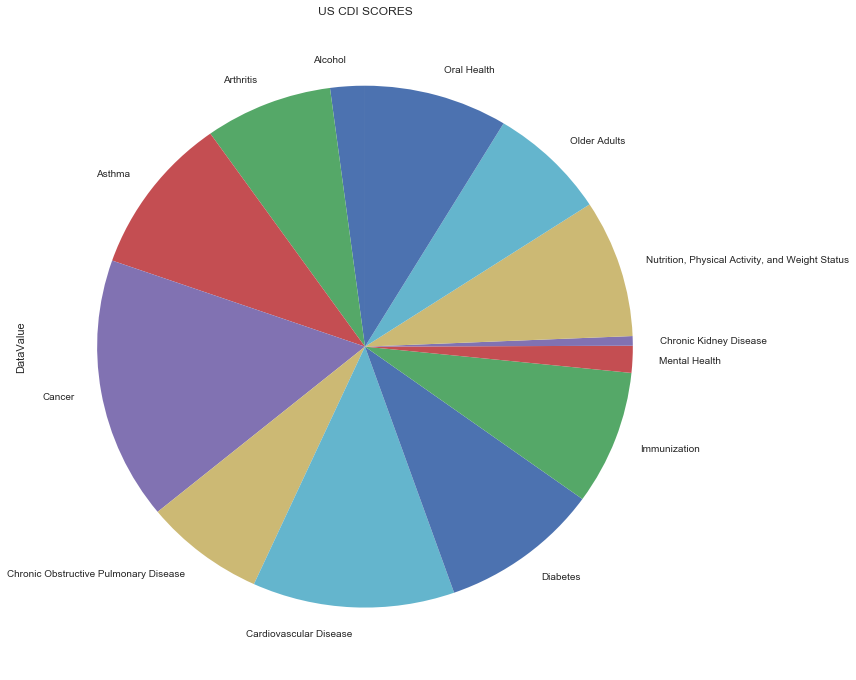

In [158]:
#create df for overall indicators in the United States
#drop columns that are empty or meaningless to data analysis
to_drop = ['LocationAbbr', 'DataSource', 'DataValueUnit', 'DataValueFootnoteSymbol','GeoLocation', 
           'ResponseID', 'LocationID', 'QuestionID', 'DataValueTypeID', 'StratificationCategoryID1',
           'StratificationID1', 'DatavalueFootnote', 'TopicID', 'YearStart', 'YearEnd', 'DataValueAlt', 
           'LowConfidenceLimit','HighConfidenceLimit']

#simplify column names for usability
to_rename = {'YearStart' : "Year", 'LocationDesc' : 'Location', 
             'StratificationCategory1' : 'Category', 'Stratification1' : 'Stratification', }
cdi_p = cdi_df.drop(to_drop, axis=1)
cdi_p.rename(columns=to_rename, inplace=True)

#limit category to overall and location to US
cdi_p = cdi_p[cdi_p['Category'] == 'Overall']
cdi_p = cdi_p[cdi_p.Location == 'United States']
cdi_p = cdi_p.drop(['DataValueType', 'Category', 'Stratification'], axis=1)
cdi_p.dropna(inplace=True)

locations = cdi_p['Location'].drop_duplicates().values
topics = cdi_p['Topic'].drop_duplicates().values

#find mean of disease indicator scores
for loc in locations:
    for top in topics:
        rows = (cdi_p.Location == loc) & (cdi_p.Topic == top)
        scoreMean = cdi_p.loc[rows, 'DataValue'].mean() 
        cdi_p.loc[rows, 'DataValue'] = scoreMean
        cdi_p.loc[rows, 'DataValue'] = cdi_p.loc[rows, 'DataValue'].drop_duplicates()
             
cdi_p.dropna(inplace=True)
cdi_p = cdi_p.drop(['Question'], axis=1)
                   
print("Overall Disease Indicator Scores for the United States")
display(cdi_p[cdi_p.Location == 'United States'])
labels = cdi_p['Topic'].drop_duplicates().values
#display pie chart
cdi_p.loc[cdi_p.Location == 'United States', 'DataValue'].plot.pie(labeldistance=1.1, labels=labels, figsize=(12, 12),
                                                                    startangle=90, title="US CDI SCORES")   

In [159]:
#make a new df for lcd that only contains data data from Causes of diabetes, cancer, and kidney disease
modified_lcd_df1 = lcd_df[lcd_df["Cause Name"].str.contains('Diabetes')]
modified_lcd_df1 = modified_lcd_df1.append(lcd_df[lcd_df["Cause Name"].str.contains('Cancer')])
modified_lcd_df1 = modified_lcd_df1.append(lcd_df[lcd_df["Cause Name"].str.contains('Kidney')])

#Group by state and cause of death and then sum occurences of death
modified_lcd_df1 = modified_lcd_df1.groupby(['State','Cause Name']).sum()

# Remove unwanted Data
modified_lcd_df1 = modified_lcd_df1.drop(['Year', 'Age-adjusted Death Rate'], axis=1)
modified_lcd_df1 = modified_lcd_df1.drop(index='United States')

modified_lcd_df1

Deaths
State                Cause Name             
Alabama              Cancer           180780
                     Diabetes          24143
                     Kidney disease    18899
Alaska               Cancer            15032
                     Diabetes           1790
                     Kidney disease      729
Arizona              Cancer           184958
                     Diabetes          25235
                     Kidney disease     9361
Arkansas             Cancer           115074
                     Diabetes          15028
                     Kidney disease    11453
California           Cancer          1002719
                     Diabetes         133769
                     Kidney disease    48386
Colorado             Cancer           121844
                     Diabetes          13446
                     Kidney disease     7759
Connecticut          Cancer           124327
                     Diabetes          12413
                     Kidney disease    10272
Delaware             Cancer            33217
                     Diabetes           3847
                     Kidney disease     2681
District of Columbia Cancer            20865
                     Diabetes           3016
                     Kidney disease     1235
Florida              Cancer           737552
                     Diabetes          90131
                     Kidney disease    48353
Georgia              Cancer           270920
                     Diabetes          32463
                     Kidney disease    28517
Hawaii               Cancer            39557
                     Diabetes           4469
                     Kidney disease     3173
Idaho                Cancer            44027
                     Diabetes           6299
                     Kidney disease     2432
Illinois             Cancer           440324
                     Diabetes          51496
                     Kidney disease    43358
Indiana              Cancer           235052
                     Diabetes          31366
                     Kidney disease    23419
Iowa                 Cancer           115576
                     Diabetes          13833
                     Kidney disease     5211
Kansas               Cancer            97101
                     Diabetes          12385
                     Kidney disease     9838
Kentucky             Cancer           173977
                     Diabetes          22111
                     Kidney disease    16466
Louisiana            Cancer           167034
                     Diabetes          26445
                     Kidney disease    19913
Maine                Cancer            57029
                     Diabetes           6830
                     Kidney disease     4352
Maryland             Cancer           187172
                     Diabetes          24018
                     Kidney disease    12855
Massachusetts        Cancer           238031
                     Diabetes          22301
                     Kidney disease    22963
Michigan             Cancer           364097
                     Diabetes          49463
                     Kidney disease    29623
Minnesota            Cancer           168221
                     Diabetes          21235
                     Kidney disease    12565
Mississippi          Cancer           111950
                     Diabetes          14876
                     Kidney disease    12235
Missouri             Cancer           225835
                     Diabetes          26584
                     Kidney disease    21550
Montana              Cancer            35021
                     Diabetes           4526
                     Kidney disease     2149
Nebraska             Cancer            61435
                     Diabetes           8003
                     Kidney disease     4620
Nevada               Cancer            78794
                     Diabetes           6472
                     Kidney disease     7108
New Hampshire        Cancer      

In [160]:
#Preprocess data to make bargraph for Causes of Death in Each State
df = lcd_df[lcd_df["Cause Name"].str.contains('Diabetes')]
df = df.groupby('State').sum()
df = df.drop(['Year', 'Age-adjusted Death Rate'], axis=1)
df = df.drop(index='United States')
df = df.sort_values(by=['Deaths'])

modified_lcd_df2 = df.rename(columns={'Deaths': 'Diabetes Deaths'})

In [161]:
#Preprocessing...
df = lcd_df[lcd_df["Cause Name"].str.contains('Cancer')]
df = df.groupby('State').sum()
df = df.drop(['Year', 'Age-adjusted Death Rate'], axis=1)
df = df.drop(index='United States')
df = df.sort_values(by=['Deaths'])

modified_lcd_df2['Cancer Deaths'] = df['Deaths']

In [197]:
#Preprocess still
df = lcd_df[lcd_df["Cause Name"].str.contains('Kidney')]
df = df.groupby('State').sum()
df = df.drop(['Year', 'Age-adjusted Death Rate'], axis=1)
df = df.drop(index='United States')
df = df.sort_values(by=['Deaths'])

modified_lcd_df2['Kidney Disease Deaths'] = df['Deaths']
print( 'skewness: \n{}'.format( modified_lcd_df2.skew() ))
print( 'kurtosis: \n{}'.format( modified_lcd_df2.kurtosis() ))

skewness: 
Diabetes Deaths          2.084913
Cancer Deaths            1.974473
Kidney Disease Deaths    1.196340
dtype: float64
kurtosis: 
Diabetes Deaths          5.028994
Cancer Deaths            4.307865
Kidney Disease Deaths    0.561506
dtype: float64


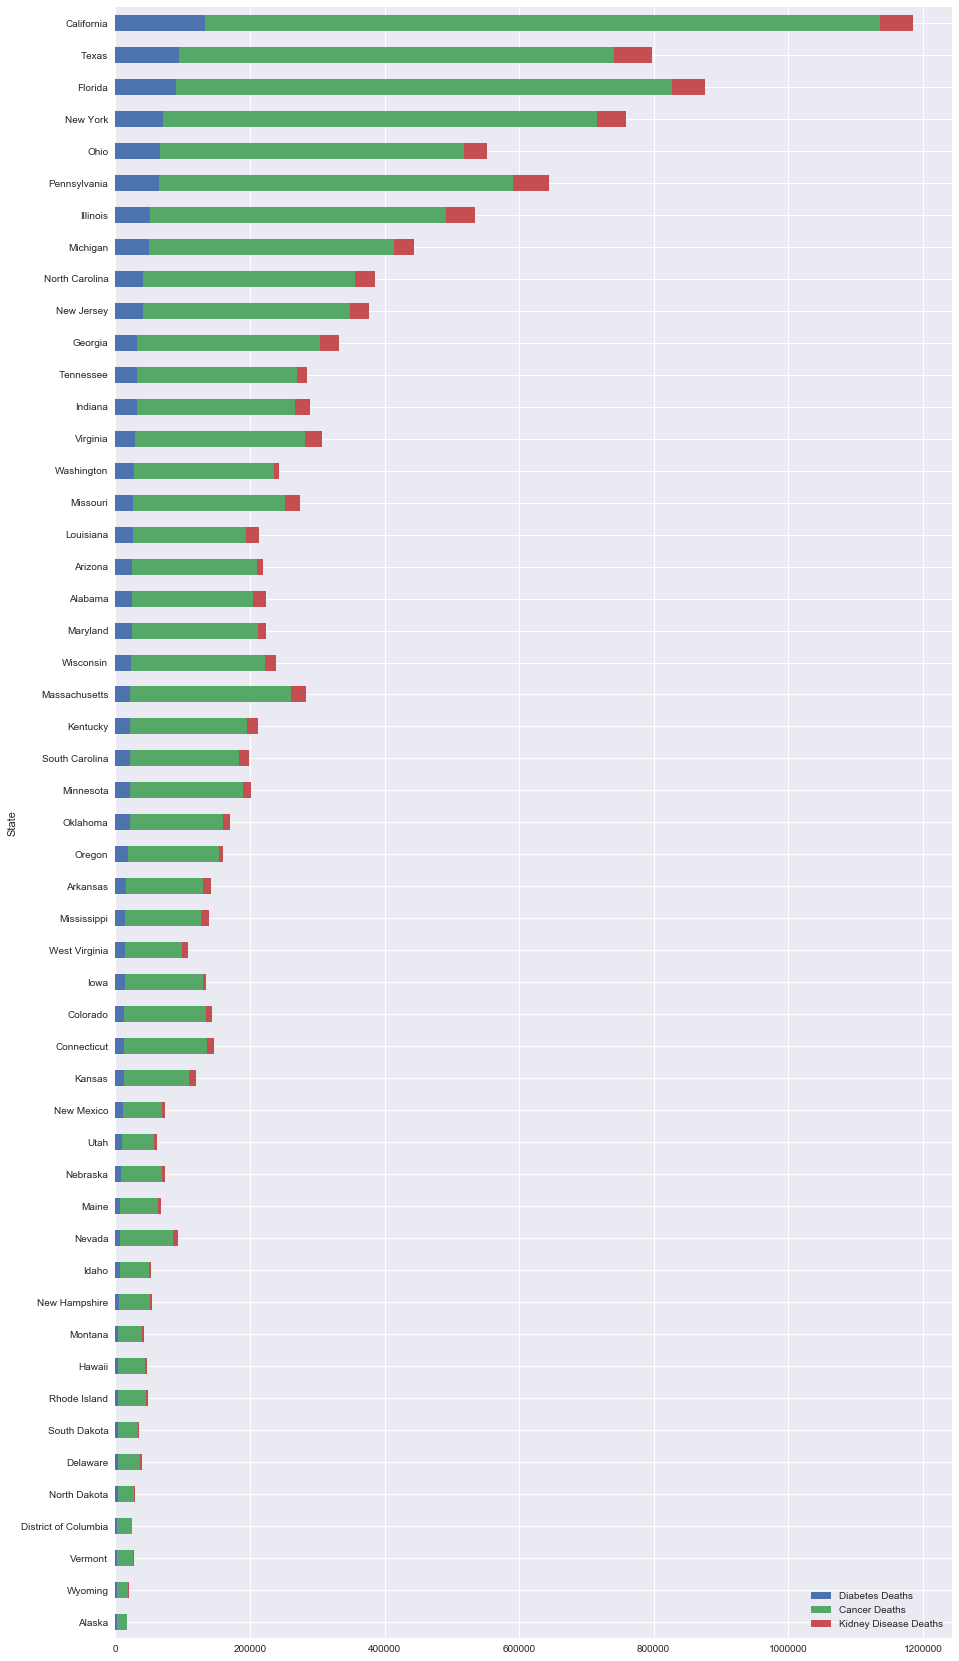

In [163]:
modified_lcd_df2.plot.barh(stacked=True,figsize=(15,30))

In [164]:
new_cdi = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi = new_cdi[new_cdi["Stratification1"].str.contains("Female")]
new_cdi = new_cdi[new_cdi["DataValueType"].str.contains('Crude')]
new_cdi = new_cdi[new_cdi["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi_female = new_cdi[['LocationDesc', 'DataValue']].copy()
new_cdi_female = new_cdi_female.rename(columns={'LocationDesc':'States and Territories'})
new_cdi_female = new_cdi_female.sort_values(by=['DataValue'])

female_alcohol_cdi = new_cdi_female.rename(columns={'DataValue': '% Female Binge Drinkers (Crude Prevalence)'})
print( 'skewness: {}'.format( female_alcohol_cdi.skew() ))
print( 'kurtosis: {}'.format( female_alcohol_cdi.kurtosis() ))


skewness: % Female Binge Drinkers (Crude Prevalence)    0.672862
dtype: float64
kurtosis: % Female Binge Drinkers (Crude Prevalence)    1.792373
dtype: float64


In [165]:
new_cdi = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi = new_cdi[new_cdi["Stratification1"].str.contains("Male")]
new_cdi = new_cdi[new_cdi["DataValueType"].str.contains('Crude')]
new_cdi = new_cdi[new_cdi["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi_male = new_cdi[['LocationDesc', 'DataValue']].copy()
new_cdi_male = new_cdi_male.rename(columns={'LocationDesc':'States and Territories'})
new_cdi_male = new_cdi_male.sort_values(by=['DataValue'])

male_alcohol_cdi = new_cdi_male.rename(columns={'DataValue':'% Male Binge Drinkers (Crude Prevalence)'})
print( 'skewness: {}'.format( male_alcohol_cdi.skew() ))
print( 'kurtosis: {}'.format( male_alcohol_cdi.kurtosis() ))

skewness: % Male Binge Drinkers (Crude Prevalence)    0.619066
dtype: float64
kurtosis: % Male Binge Drinkers (Crude Prevalence)    0.535725
dtype: float64


In [166]:
new_cdi2 = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi2 = new_cdi2[new_cdi2["Stratification1"].str.contains("Female")]
new_cdi2 = new_cdi2[new_cdi2["DataValueType"].str.contains('Age-adjusted')]
new_cdi2 = new_cdi2[new_cdi2["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi_female2 = new_cdi2[['LocationDesc', 'DataValue']].copy()
new_cdi_female2 = new_cdi_female2.rename(columns={'LocationDesc':'States and Territories'})
new_cdi_female2 = new_cdi_female2.sort_values(by=['DataValue'])

female_alcohol_cdi2 = new_cdi_female2.rename(columns={'DataValue': '% Female Binge Drinkers (Age-Adjusted Prevalence)'})
print( 'skewness: {}'.format( female_alcohol_cdi2.skew() ))
print( 'kurtosis: {}'.format( female_alcohol_cdi2.kurtosis() ))

skewness: % Female Binge Drinkers (Age-Adjusted Prevalence)    0.343626
dtype: float64
kurtosis: % Female Binge Drinkers (Age-Adjusted Prevalence)    0.586353
dtype: float64


In [199]:
new_cdi2 = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi2 = new_cdi2[new_cdi2["Stratification1"].str.contains("Male")]
new_cdi2 = new_cdi2[new_cdi2["DataValueType"].str.contains('Age-adjusted')]
new_cdi2 = new_cdi2[new_cdi2["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi_male2 = new_cdi2[['LocationDesc', 'DataValue']].copy()
new_cdi_male2 = new_cdi_male2.rename(columns={'LocationDesc':'States and Territories'})
new_cdi_male2 = new_cdi_male2.sort_values(by=['DataValue'])

male_alcohol_cdi2 = new_cdi_male2.rename(columns={'DataValue': '% Male Binge Drinkers (Age-Adjusted Prevalence)'})
print( 'skewness: {}'.format( male_alcohol_cdi2.skew() ))
print( 'kurtosis: {}'.format( male_alcohol_cdi2.kurtosis() ))

skewness: % Male Binge Drinkers (Age-Adjusted Prevalence)    0.319344
dtype: float64
kurtosis: % Male Binge Drinkers (Age-Adjusted Prevalence)   -0.013573
dtype: float64


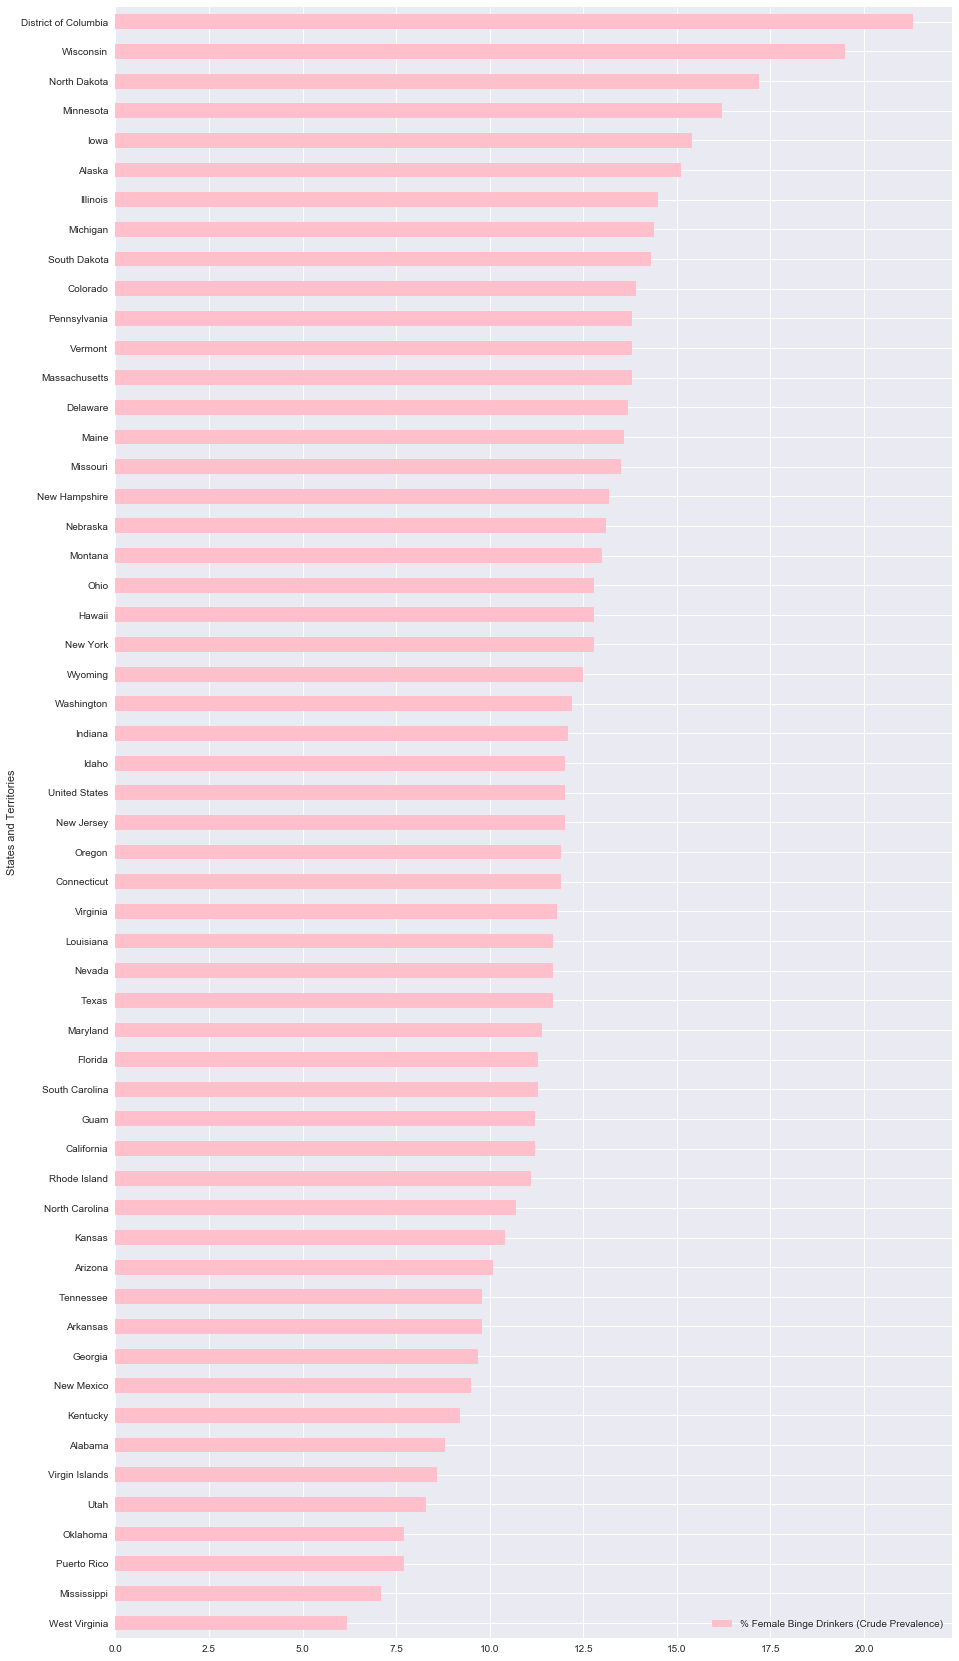

In [168]:
#Overall female binge drinkers (Crude Prevalence)
female_alcohol_cdi.set_index('States and Territories').plot.barh(stacked=True, color='pink',figsize=(15,30))

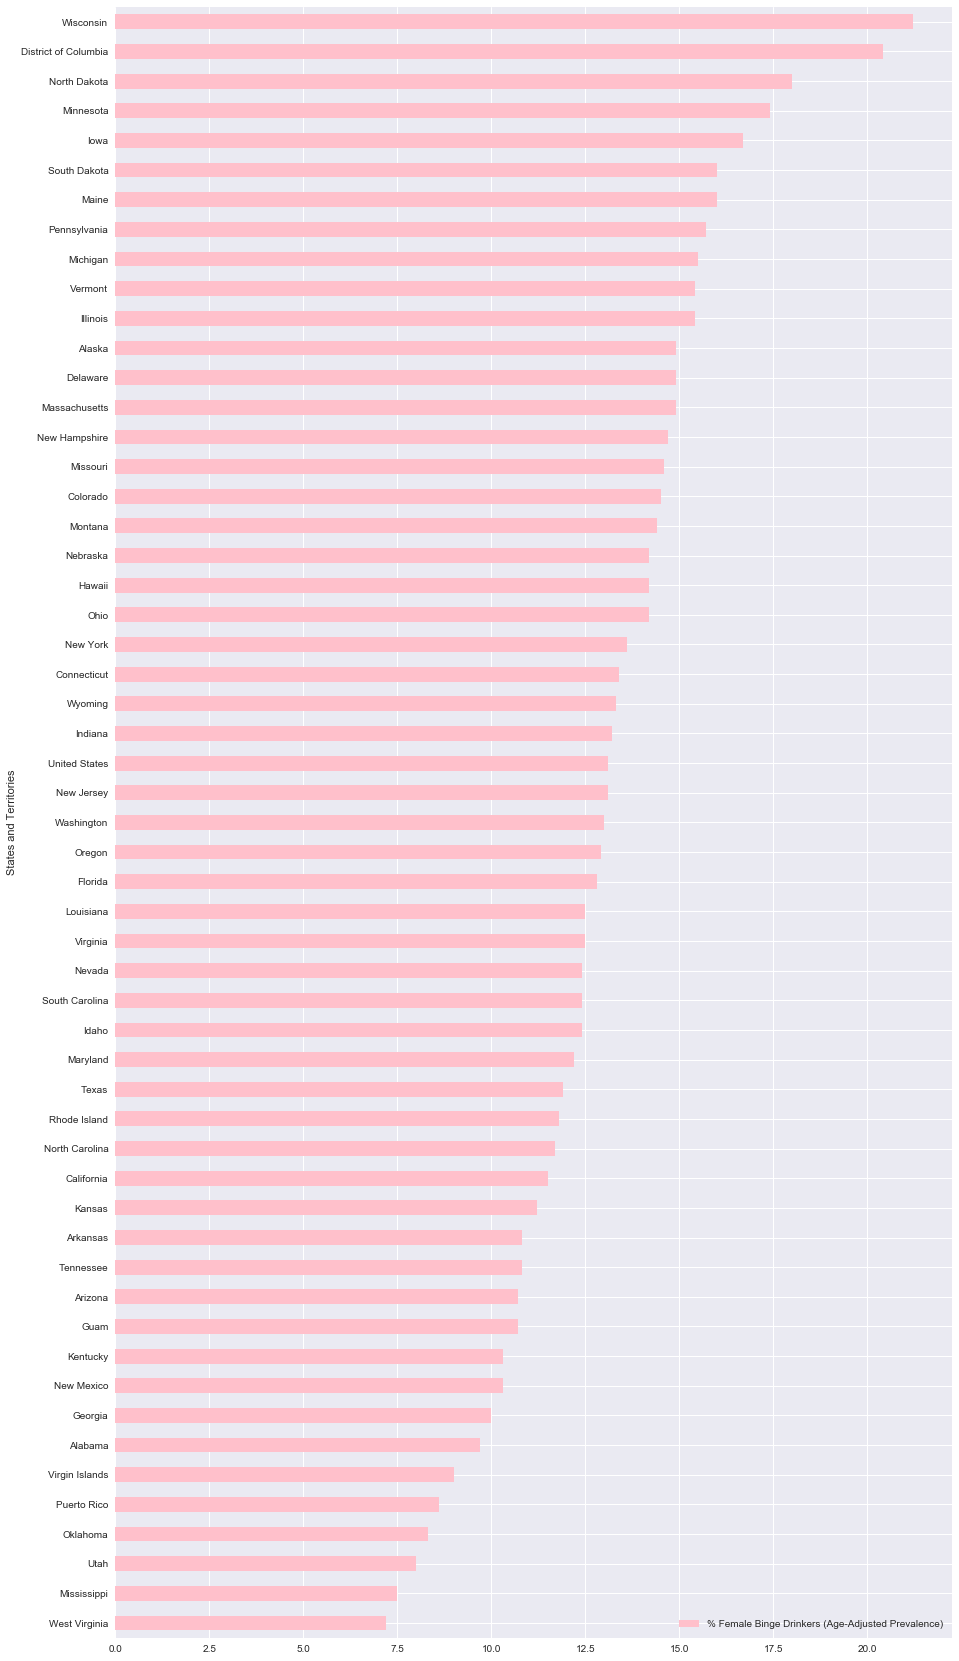

In [169]:
#Overall female binge drinkers (Age-adjusted Prevalence)
female_alcohol_cdi2.set_index('States and Territories').plot.barh(stacked=True, color='pink',figsize=(15,30))

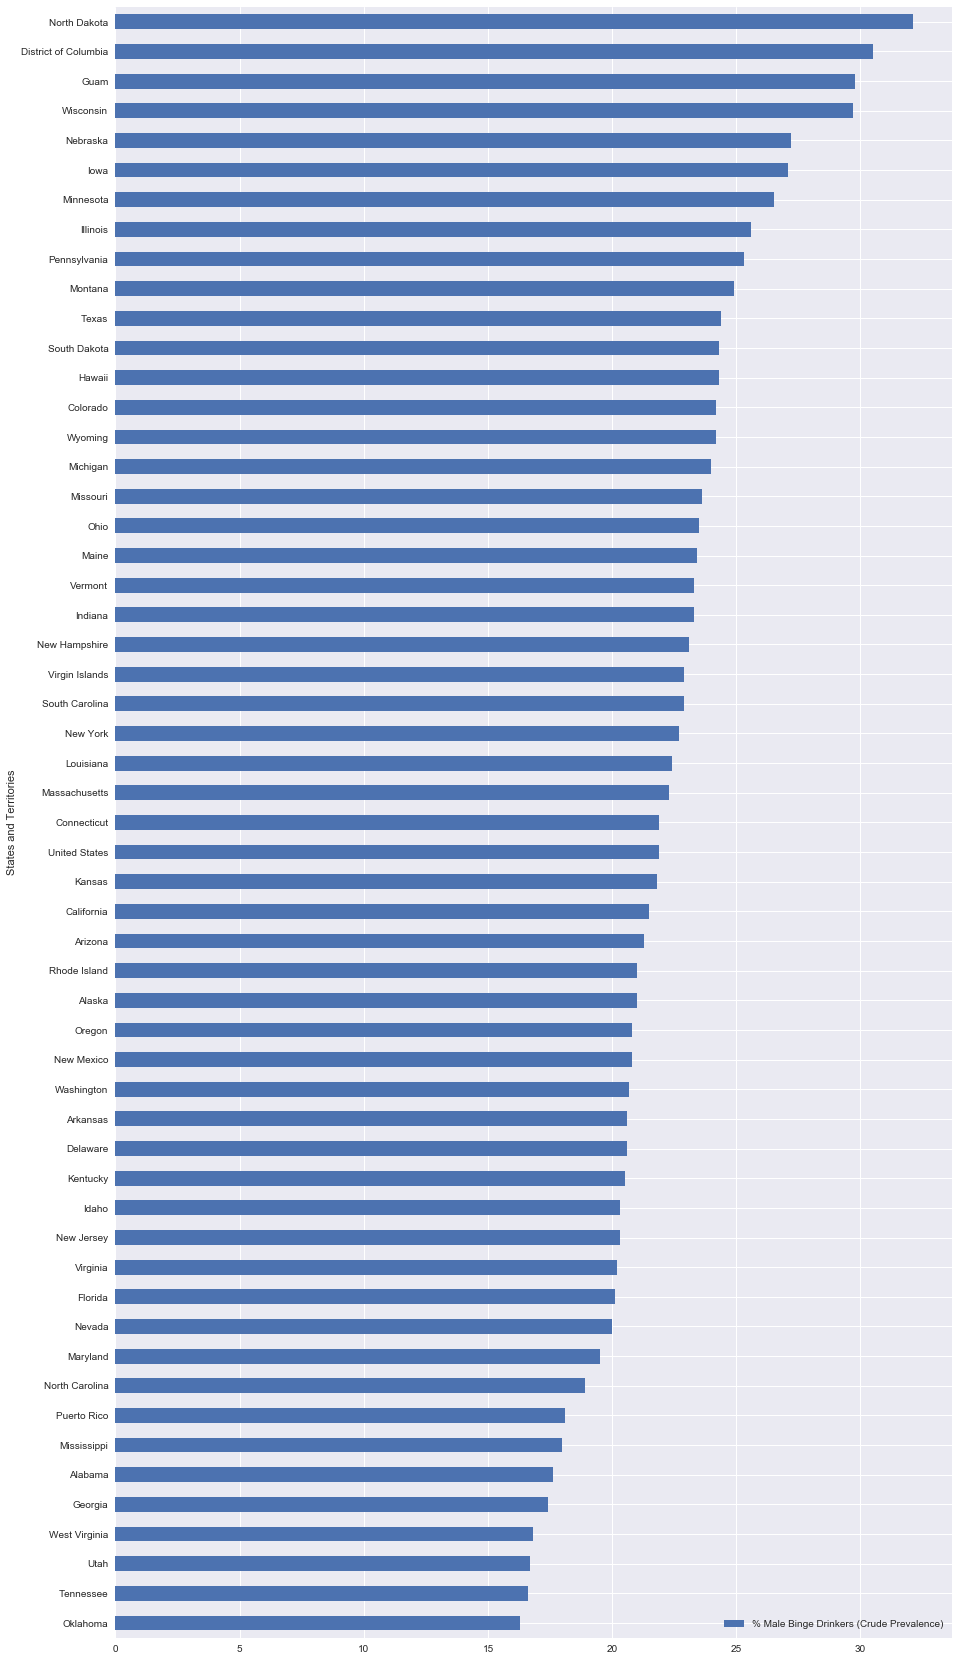

In [170]:
#Overall male binge drinking (crude prevalence)
male_alcohol_cdi.set_index('States and Territories').plot.barh(stacked=True,figsize=(15,30))

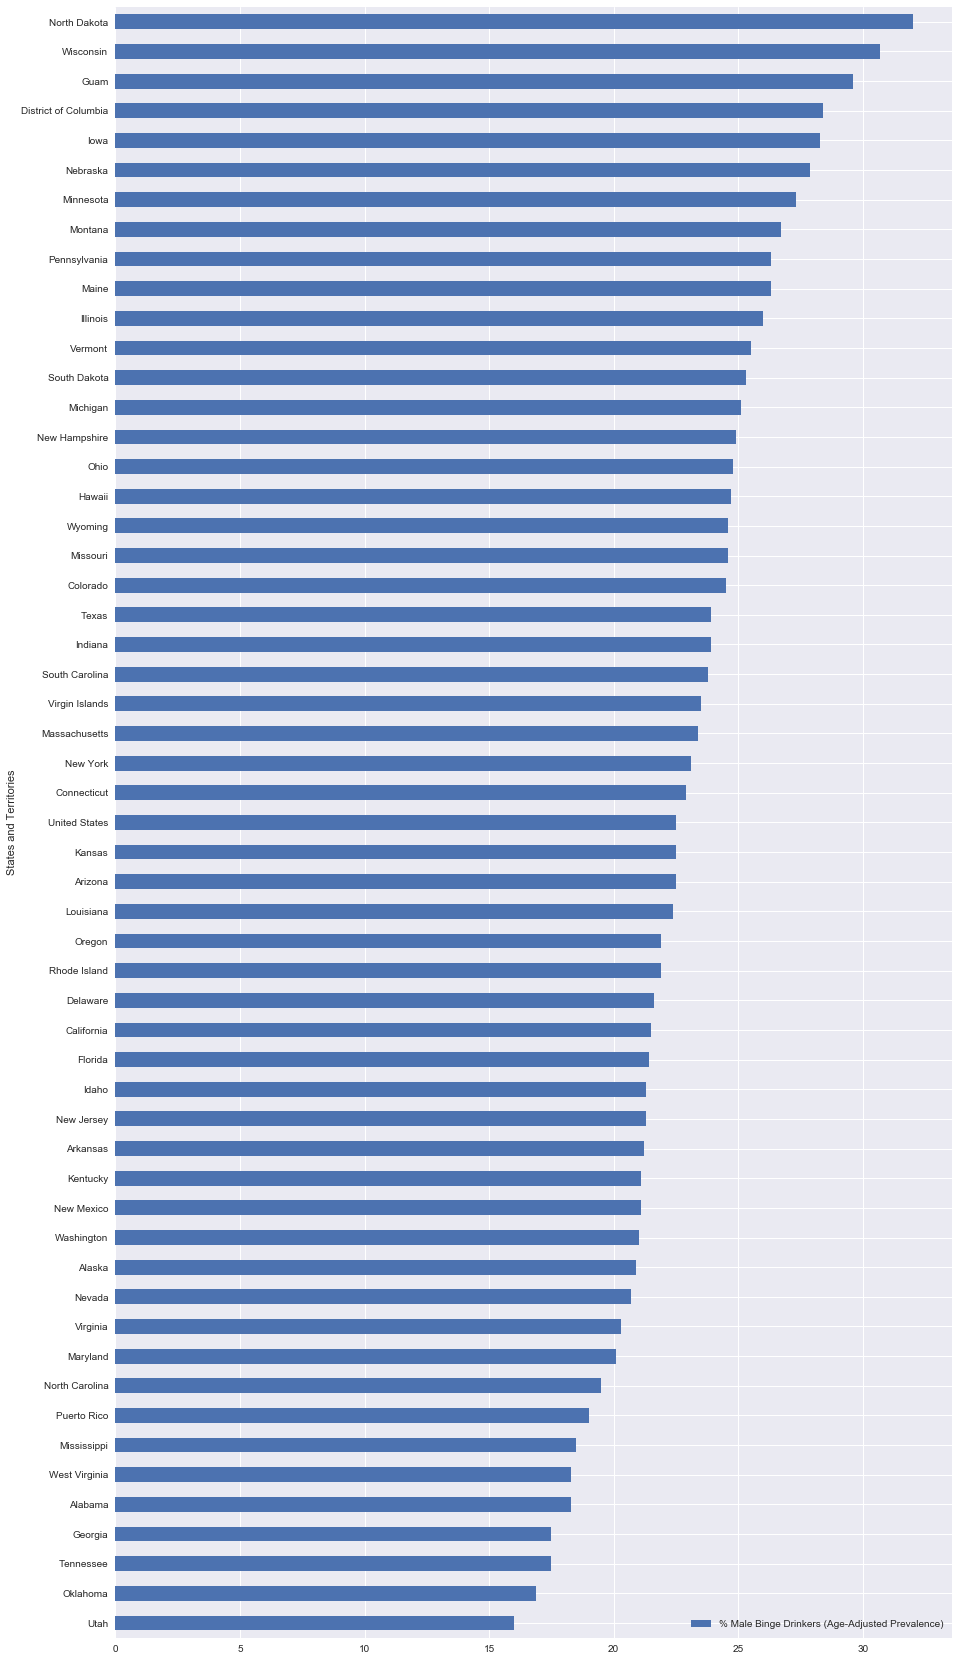

In [171]:
#Overall male binge drinking (Age-Adjusted Prevalence)
male_alcohol_cdi2.set_index('States and Territories').plot.barh(stacked=True,figsize=(15,30))

In [172]:
new_cdi = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi = new_cdi[new_cdi["Stratification1"].str.contains("White")]
new_cdi = new_cdi[new_cdi["DataValueType"].str.contains('Crude')]
new_cdi = new_cdi[new_cdi["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi = new_cdi[['LocationDesc', 'DataValue']].copy()
new_cdi = new_cdi.rename(columns={'LocationDesc':'States and Territories'})
new_cdi = new_cdi.sort_values(by=['DataValue'])

white_alcohol_cdi = new_cdi.rename(columns={'DataValue': '% White, non-Hispanic Binge Drinkers (Crude Prevalence)'})
print( 'skewness: {}'.format( white_alcohol_cdi.skew() ))
print( 'kurtosis: {}'.format( white_alcohol_cdi.kurtosis() ))

skewness: % White, non-Hispanic Binge Drinkers (Crude Prevalence)    2.134811
dtype: float64
kurtosis: % White, non-Hispanic Binge Drinkers (Crude Prevalence)    6.877032
dtype: float64


In [173]:
new_cdi2 = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi2 = new_cdi2[new_cdi2["Stratification1"].str.contains("Black")]
new_cdi2 = new_cdi2[new_cdi2["DataValueType"].str.contains('Crude')]
new_cdi2 = new_cdi2[new_cdi2["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi2 = new_cdi2[['LocationDesc', 'DataValue']].copy()
new_cdi2 = new_cdi2.rename(columns={'LocationDesc':'States and Territories'})
new_cdi2 = new_cdi2.sort_values(by=['DataValue'])

black_alcohol_cdi = new_cdi.rename(columns={'DataValue': '% Black, non-Hispanic Binge Drinkers (Crude Prevalence)'})
print( 'skewness: {}'.format( black_alcohol_cdi.skew() ))
print( 'kurtosis: {}'.format( black_alcohol_cdi.kurtosis() ))

skewness: % Black, non-Hispanic Binge Drinkers (Crude Prevalence)    2.134811
dtype: float64
kurtosis: % Black, non-Hispanic Binge Drinkers (Crude Prevalence)    6.877032
dtype: float64


In [174]:
new_cdi3 = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi3 = new_cdi3[new_cdi3["Stratification1"] == 'Hispanic']
new_cdi3 = new_cdi3[new_cdi3["DataValueType"].str.contains('Crude')]
new_cdi3 = new_cdi3[new_cdi3["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi3 = new_cdi3[['LocationDesc', 'DataValue']].copy()
new_cdi3 = new_cdi3.rename(columns={'LocationDesc':'States and Territories'})
new_cdi3 = new_cdi3.sort_values(by=['DataValue'])

hispanic_alcohol_cdi = new_cdi3.rename(columns={'DataValue': '% Hispanic Binge Drinkers (Crude Prevalence)'})
print( 'skewness: {}'.format( hispanic_alcohol_cdi.skew() ))
print( 'kurtosis: {}'.format( hispanic_alcohol_cdi.kurtosis() ))

skewness: % Hispanic Binge Drinkers (Crude Prevalence)    1.361858
dtype: float64
kurtosis: % Hispanic Binge Drinkers (Crude Prevalence)    0.923593
dtype: float64


In [175]:
new_cdi4 = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi4 = new_cdi4[new_cdi4["Stratification1"].str.contains("Other")]
new_cdi4 = new_cdi4[new_cdi4["DataValueType"].str.contains('Crude')]
new_cdi4 = new_cdi4[new_cdi4["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi4 = new_cdi4[['LocationDesc', 'DataValue']].copy()
new_cdi4 = new_cdi4.rename(columns={'LocationDesc':'States and Territories'})
new_cdi4 = new_cdi4.sort_values(by=['DataValue'])

other_alcohol_cdi = new_cdi4.rename(columns={'DataValue': '% Other, non-Hispanic Binge Drinkers (Crude Prevalence)'})
print( 'skewness: {}'.format( other_alcohol_cdi.skew() ))
print( 'kurtosis: {}'.format( other_alcohol_cdi.kurtosis() ))

skewness: % Other, non-Hispanic Binge Drinkers (Crude Prevalence)    0.728571
dtype: float64
kurtosis: % Other, non-Hispanic Binge Drinkers (Crude Prevalence)   -1.024565
dtype: float64


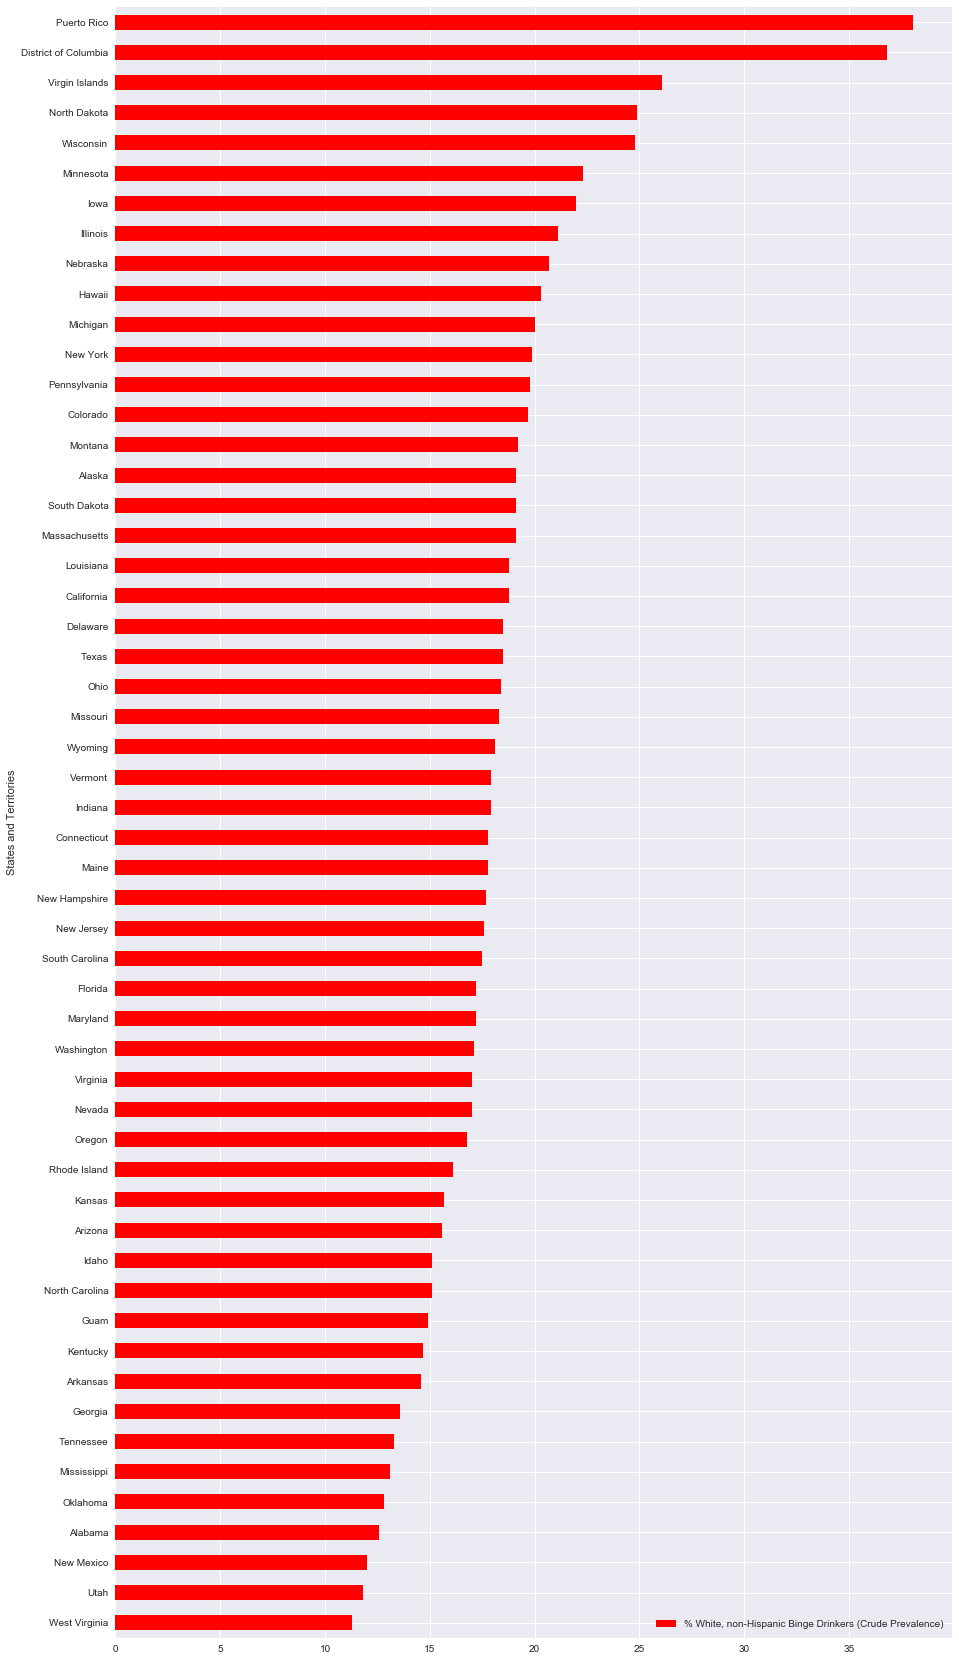

In [176]:
white_alcohol_cdi.set_index('States and Territories').plot.barh(stacked=True, color='red', figsize=(15,30))

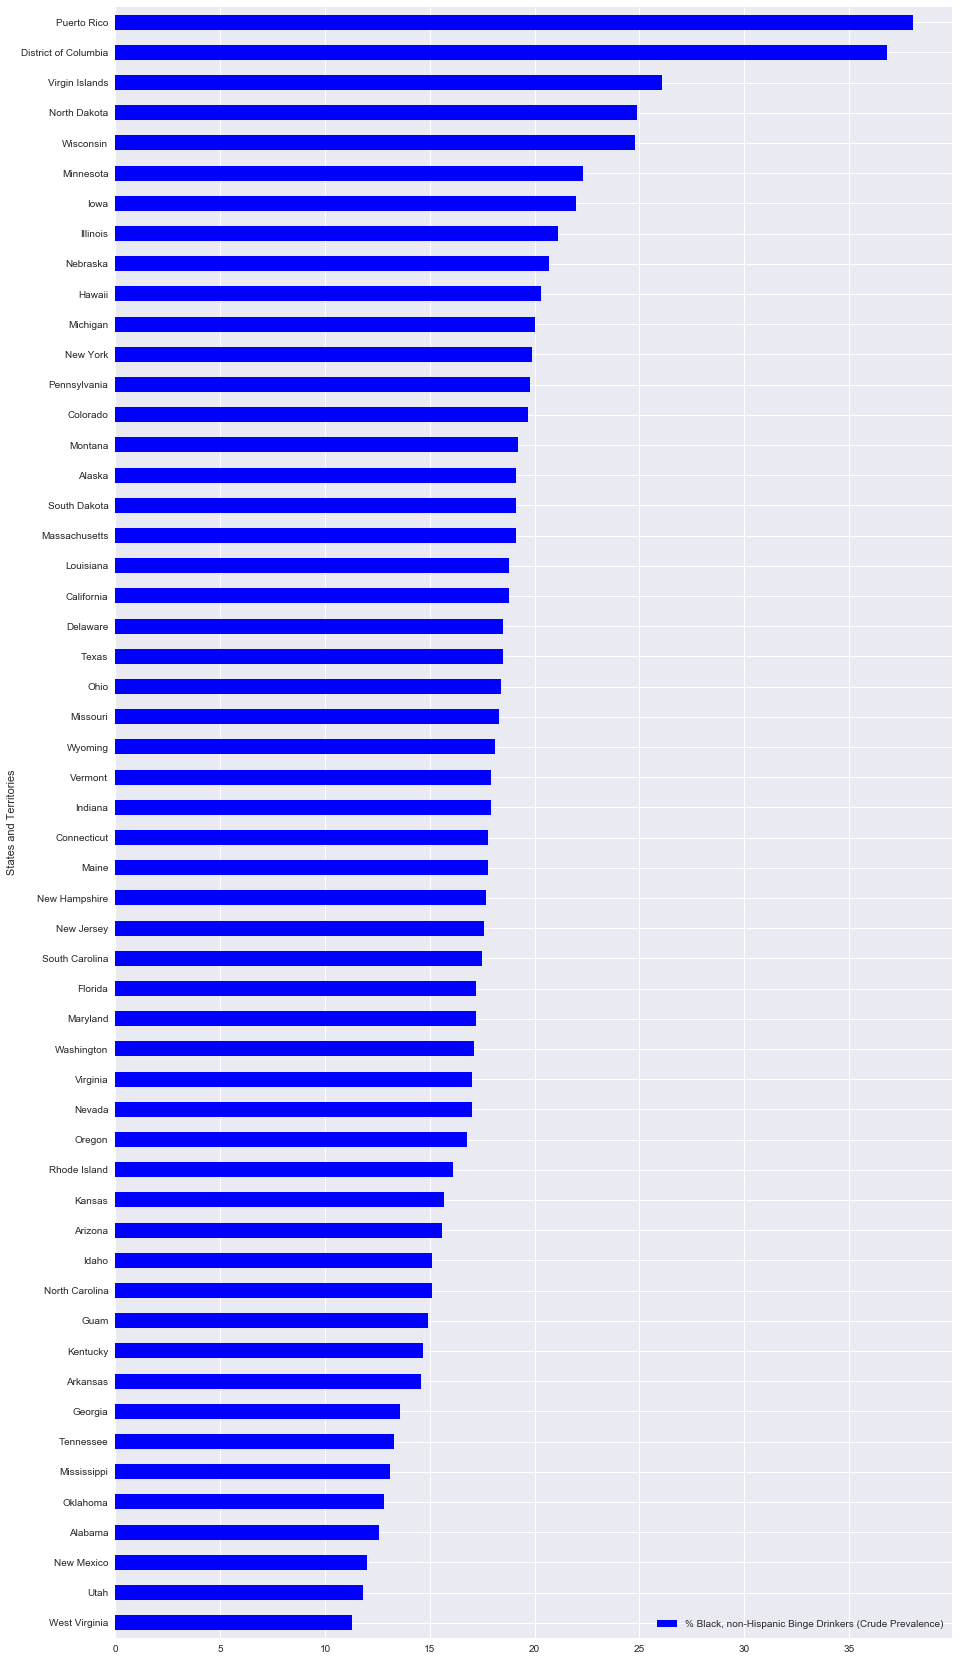

In [177]:
black_alcohol_cdi.set_index('States and Territories').plot.barh(stacked=True, color='blue',figsize=(15,30))

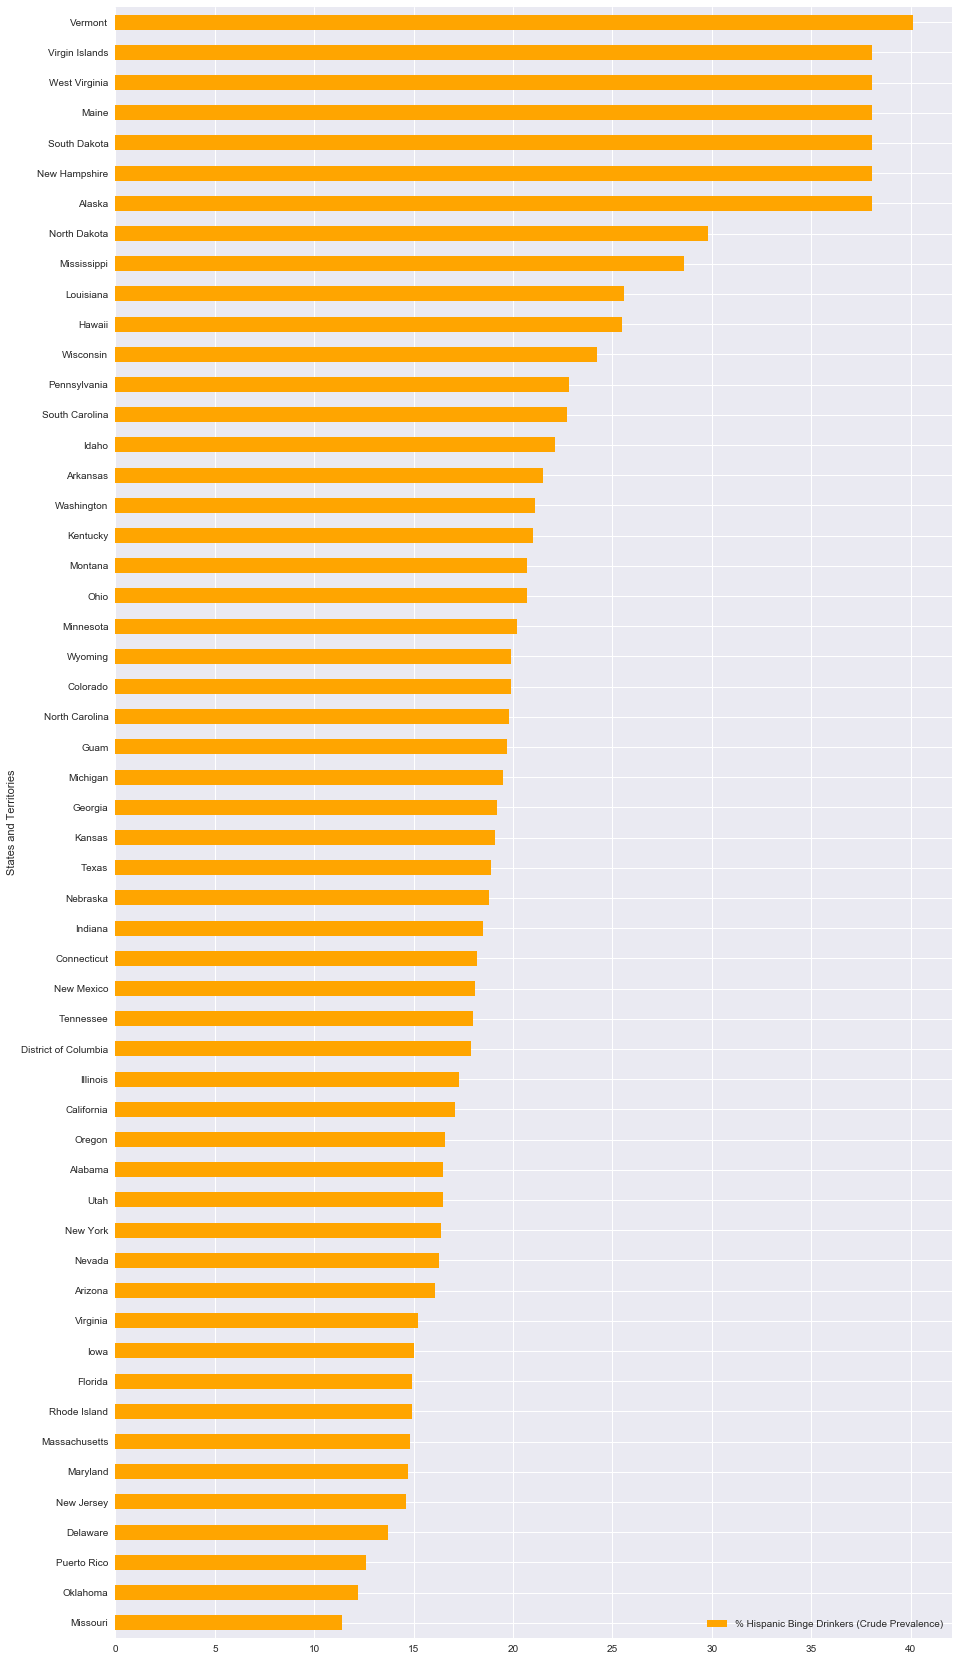

In [178]:
hispanic_alcohol_cdi.set_index('States and Territories').plot.barh(stacked=True, color='orange',figsize=(15,30))

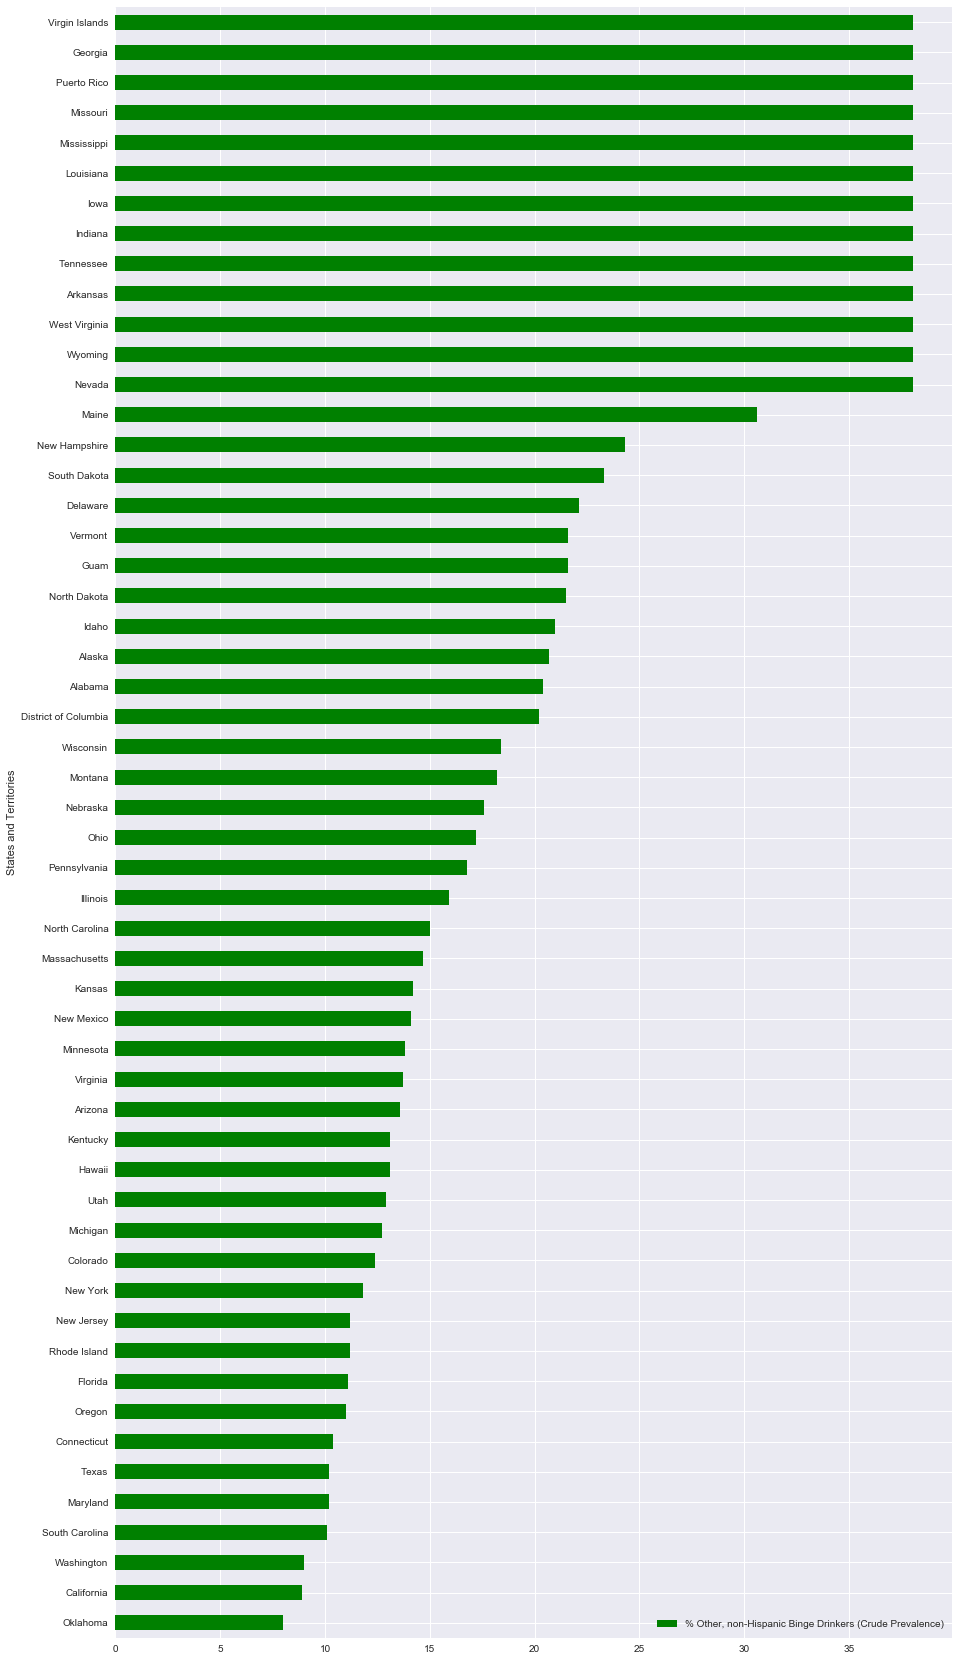

In [179]:
other_alcohol_cdi.set_index('States and Territories').plot.barh(stacked=True, color='green',figsize=(15,30))

In [180]:
new_cdi = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi = new_cdi[new_cdi["Stratification1"].str.contains("White")]
new_cdi = new_cdi[new_cdi["DataValueType"].str.contains('Age-adjusted')]
new_cdi = new_cdi[new_cdi["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi = new_cdi[['LocationDesc', 'DataValue']].copy()
new_cdi = new_cdi.rename(columns={'LocationDesc':'States and Territories'})
new_cdi = new_cdi.sort_values(by=['DataValue'])

white_alcohol_cdi2 = new_cdi.rename(columns={'DataValue': '% White, non-Hispanic Binge Drinkers (Age-adjusted)'})
print( 'skewness: {}'.format( white_alcohol_cdi2.skew() ))
print( 'kurtosis: {}'.format( white_alcohol_cdi2.kurtosis() ))

skewness: % White, non-Hispanic Binge Drinkers (Age-adjusted)    1.340794
dtype: float64
kurtosis: % White, non-Hispanic Binge Drinkers (Age-adjusted)    3.660168
dtype: float64


In [181]:
new_cdi2 = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi2 = new_cdi2[new_cdi2["Stratification1"].str.contains("Black")]
new_cdi2 = new_cdi2[new_cdi2["DataValueType"].str.contains('Age-adjusted')]
new_cdi2 = new_cdi2[new_cdi2["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi2 = new_cdi2[['LocationDesc', 'DataValue']].copy()
new_cdi2 = new_cdi2.rename(columns={'LocationDesc':'States and Territories'})
new_cdi2 = new_cdi2.sort_values(by=['DataValue'])

black_alcohol_cdi2 = new_cdi2.rename(columns={'DataValue': '% Black, non-Hispanic Binge Drinkers (Age-Adjusted)'})
print( 'skewness: {}'.format( black_alcohol_cdi2.skew() ))
print( 'kurtosis: {}'.format( black_alcohol_cdi2.kurtosis() ))

skewness: % Black, non-Hispanic Binge Drinkers (Age-Adjusted)    0.824264
dtype: float64
kurtosis: % Black, non-Hispanic Binge Drinkers (Age-Adjusted)   -1.161681
dtype: float64


In [182]:
new_cdi3 = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi3 = new_cdi3[new_cdi3["Stratification1"] == 'Hispanic']
new_cdi3 = new_cdi3[new_cdi3["DataValueType"].str.contains('Age-adjusted')]
new_cdi3 = new_cdi3[new_cdi3["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi3 = new_cdi3[['LocationDesc', 'DataValue']].copy()
new_cdi3 = new_cdi3.rename(columns={'LocationDesc':'States and Territories'})
new_cdi3 = new_cdi3.sort_values(by=['DataValue'])

hispanic_alcohol_cdi2 = new_cdi3.rename(columns={'DataValue': '% Hispanic Binge Drinkers (Age-Adjusted)'})
print( 'skewness: {}'.format( hispanic_alcohol_cdi2.skew() ))
print( 'kurtosis: {}'.format( hispanic_alcohol_cdi2.kurtosis() ))

skewness: % Hispanic Binge Drinkers (Age-Adjusted)    1.781999
dtype: float64
kurtosis: % Hispanic Binge Drinkers (Age-Adjusted)    2.678122
dtype: float64


In [183]:
new_cdi4 = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi4 = new_cdi4[new_cdi4["Stratification1"].str.contains("Other")]
new_cdi4 = new_cdi4[new_cdi4["DataValueType"].str.contains('Age-adjusted')]
new_cdi4 = new_cdi4[new_cdi4["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi4 = new_cdi4[['LocationDesc', 'DataValue']].copy()
new_cdi4 = new_cdi4.rename(columns={'LocationDesc':'States and Territories'})
new_cdi4 = new_cdi4.sort_values(by=['DataValue'])

other_alcohol_cdi2 = new_cdi4.rename(columns={'DataValue': '% Other, non-Hispanic Binge Drinkers (Age-Adjusted)'})
print( 'skewness: {}'.format( other_alcohol_cdi2.skew() ))
print( 'kurtosis: {}'.format( other_alcohol_cdi2.kurtosis() ))

skewness: % Other, non-Hispanic Binge Drinkers (Age-Adjusted)    0.942073
dtype: float64
kurtosis: % Other, non-Hispanic Binge Drinkers (Age-Adjusted)   -0.595031
dtype: float64


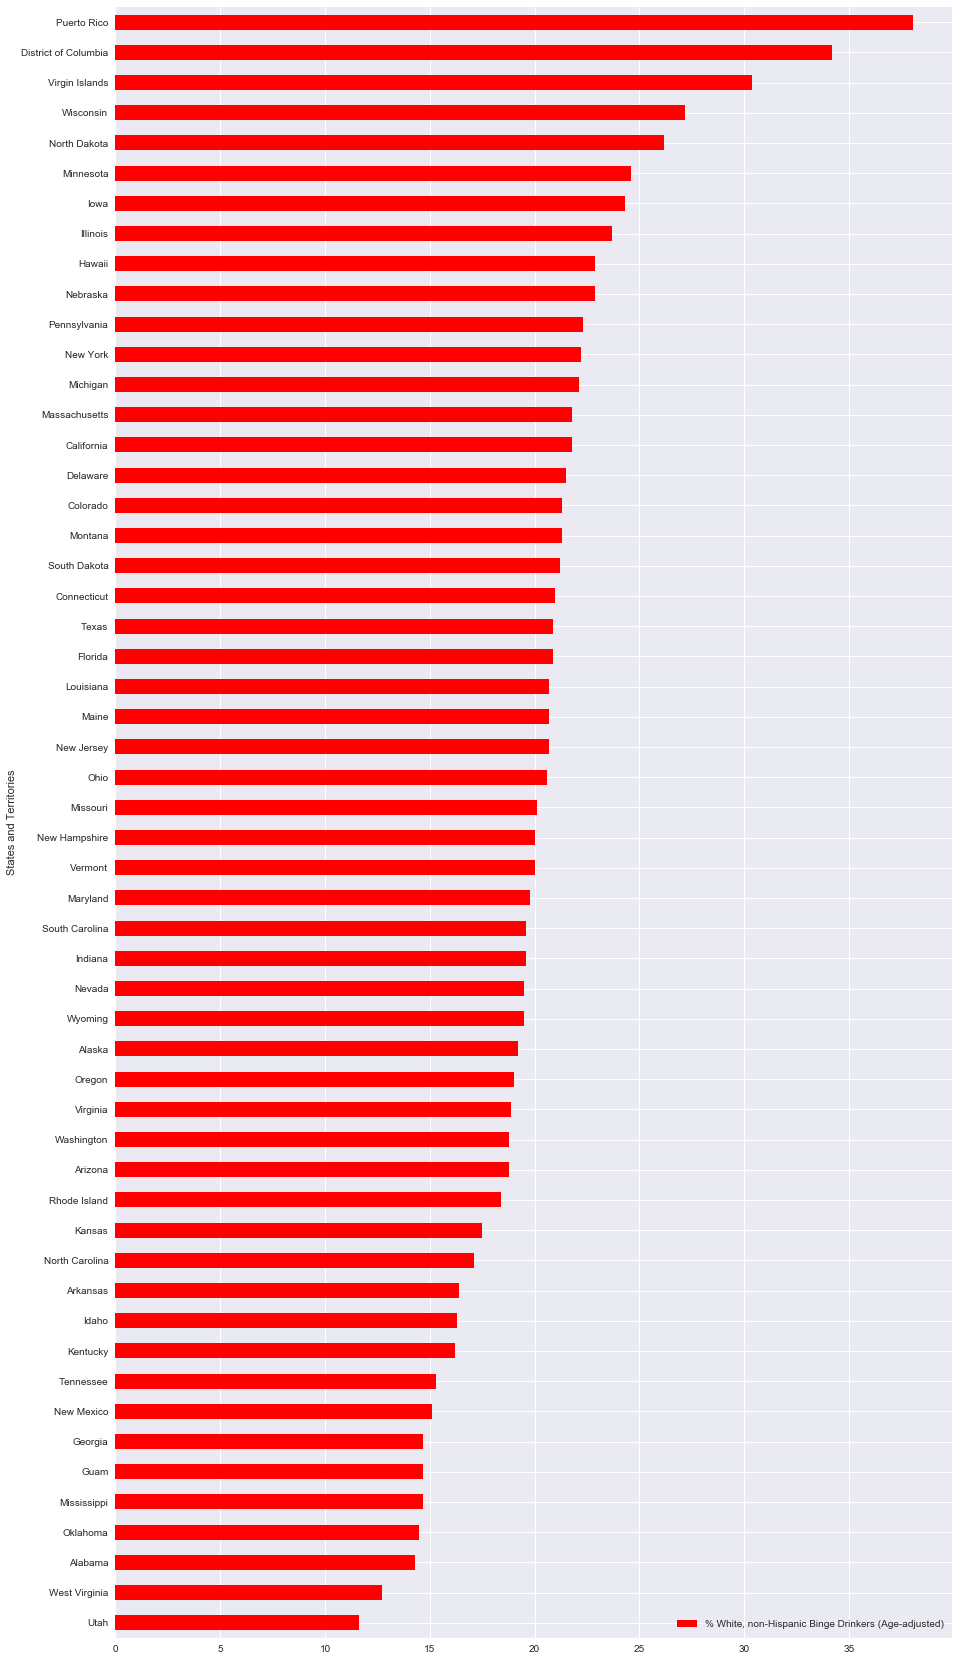

In [184]:

white_alcohol_cdi2.set_index('States and Territories').plot.barh(stacked=True, color='red', figsize=(15,30))

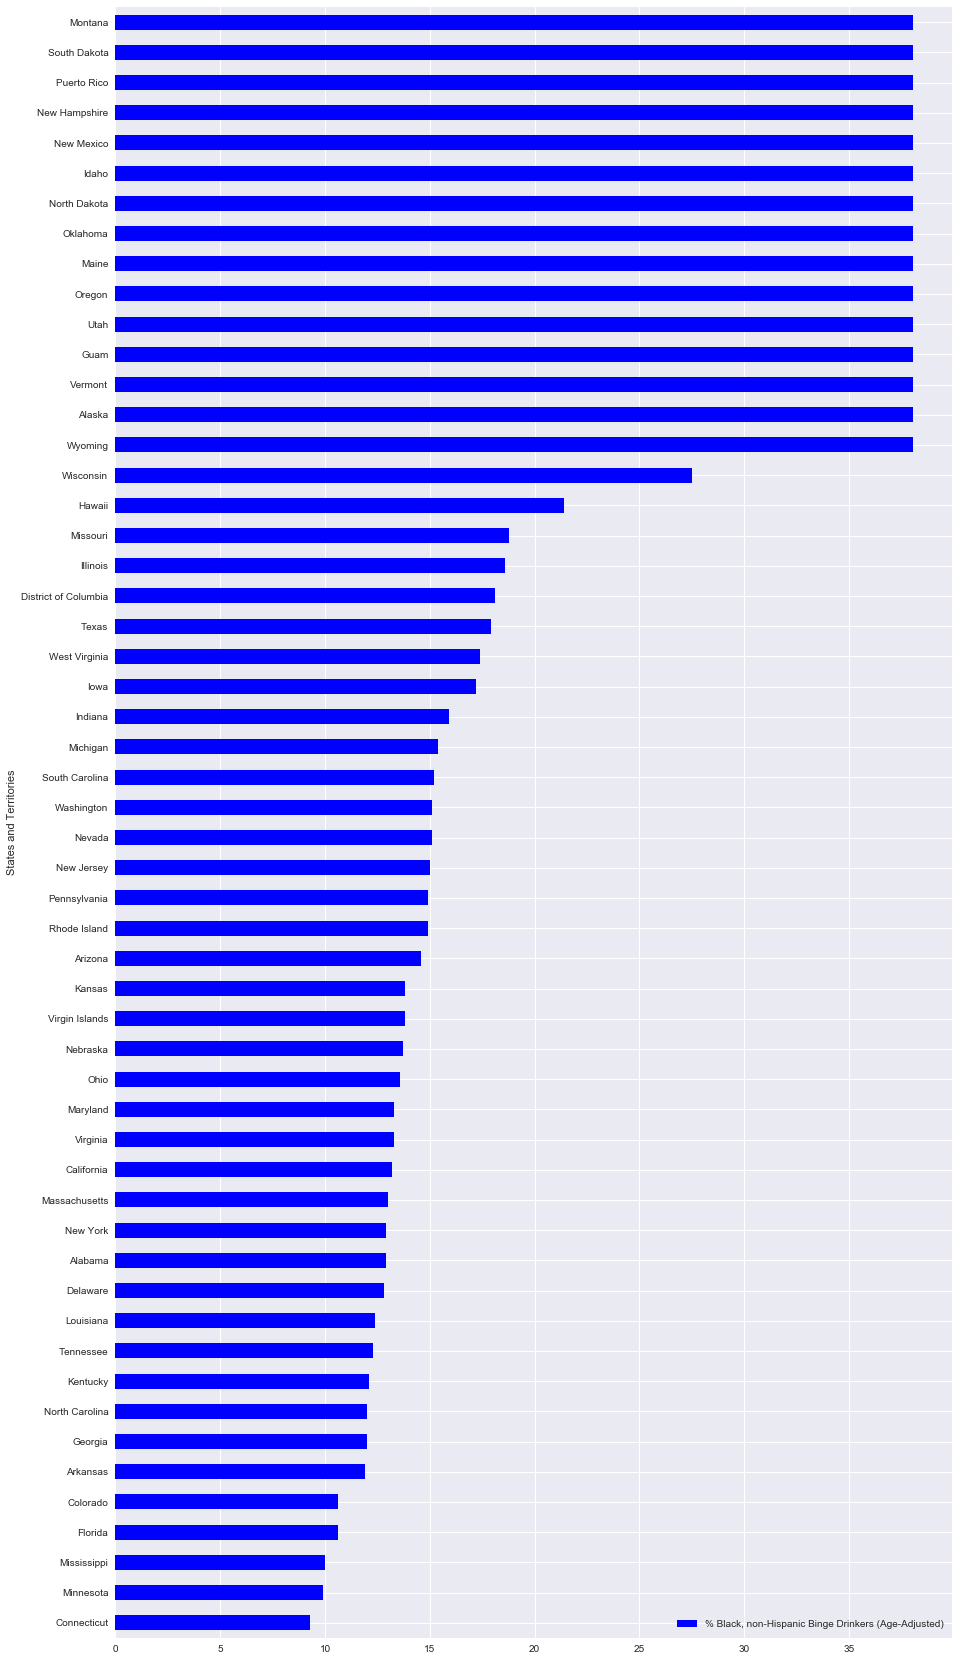

In [185]:
black_alcohol_cdi2.set_index('States and Territories').plot.barh(stacked=True, color='blue',figsize=(15,30))

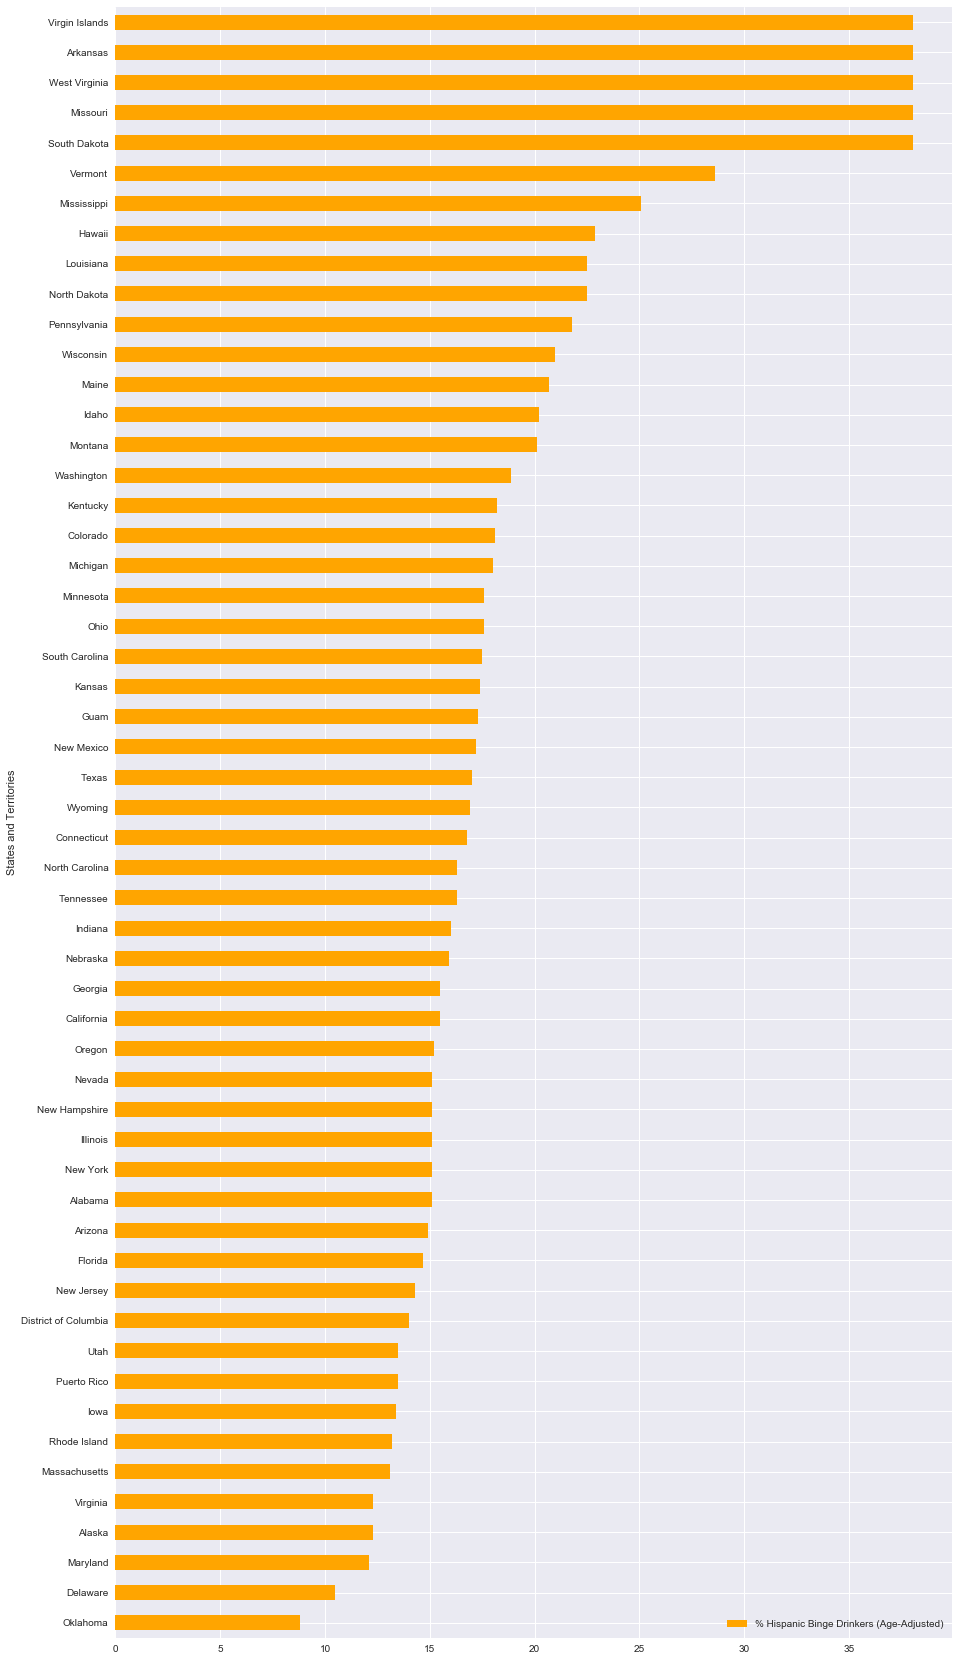

In [186]:
hispanic_alcohol_cdi2.set_index('States and Territories').plot.barh(stacked=True, color='orange',figsize=(15,30))

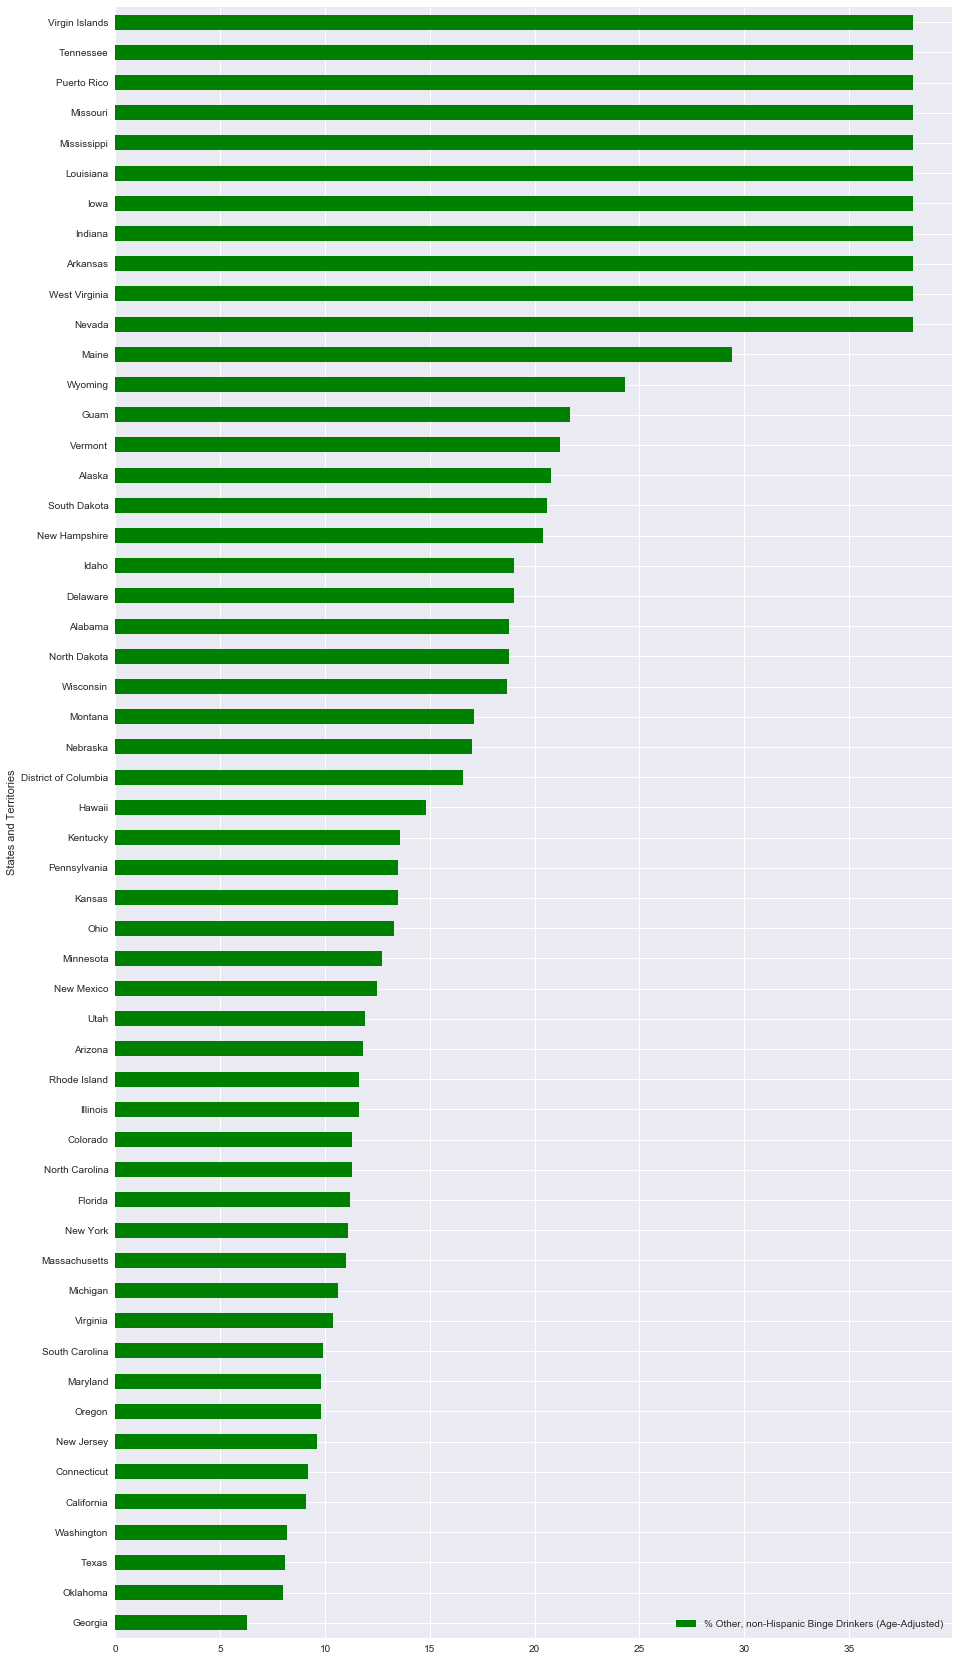

In [187]:
other_alcohol_cdi2.set_index('States and Territories').plot.barh(stacked=True, color='green',figsize=(15,30))

          DataValue  Stratification1
clusters                            
0         22.340000                2
1         12.114545                1
skewness: DataValue          0.255063
Stratification1    0.000000
clusters           0.000000
dtype: float64
kurtosis: DataValue         -0.873717
Stratification1   -2.037383
clusters          -2.037383
dtype: float64


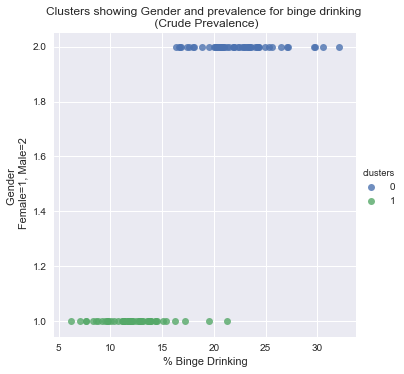

In [188]:
new_cdi = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi = new_cdi[new_cdi["DataValueType"] == 'Crude Prevalence']
new_cdi = new_cdi[new_cdi["StratificationCategory1"].str.contains('Gender')]
new_cdi = new_cdi[new_cdi["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi = new_cdi[['StratificationCategory1', 'DataValue', 'LocationDesc', 'Stratification1']].copy()

new_cdi = new_cdi.replace('Female', 1)
new_cdi = new_cdi.replace('Male', 2)

pd.to_numeric(new_cdi['DataValue'])
columns = ['DataValue', 'Stratification1']
standardized = stats.zscore(new_cdi[columns])

kmeans = KMeans(n_clusters=2, random_state=0).fit(standardized)
labels = kmeans.labels_

new_cdi['clusters'] = labels

columns.extend(['clusters'])

print(new_cdi[columns].groupby(['clusters']).mean())

sns.lmplot('DataValue', 'Stratification1',
          data=new_cdi,
          fit_reg=False,
          hue="clusters",)
plt.title('Clusters showing Gender and prevalence for binge drinking \n (Crude Prevalence)')
plt.xlabel('% Binge Drinking')
plt.ylabel('Gender \n Female=1, Male=2')

print( 'skewness: {}'.format( new_cdi.skew() ))
print( 'kurtosis: {}'.format( new_cdi.kurtosis() ))

          DataValue  Stratification1
clusters                            
0         37.080656         2.250000
1         18.231111         3.000000
2         37.271024         4.681818
3         16.108989         1.415730
4         16.760938         4.375000
skewness: DataValue          0.740777
Stratification1    0.000000
clusters          -0.467789
dtype: float64
kurtosis: DataValue         -0.952447
Stratification1   -1.301843
clusters          -0.929804
dtype: float64


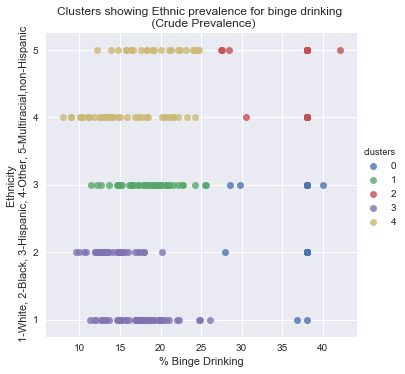

In [189]:
new_cdi = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi = new_cdi[new_cdi["DataValueType"] == 'Crude Prevalence']
new_cdi = new_cdi[new_cdi["StratificationCategory1"].str.contains('Race/Ethnicity')]
new_cdi = new_cdi[new_cdi["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi = new_cdi[['StratificationCategory1', 'DataValue', 'LocationDesc', 'Stratification1']].copy()

new_cdi = new_cdi.replace('White, non-Hispanic', 1)
new_cdi = new_cdi.replace('Black, non-Hispanic', 2)
new_cdi = new_cdi.replace('Hispanic', 3)
new_cdi = new_cdi.replace('Other, non-Hispanic', 4)
new_cdi = new_cdi.replace('Multiracial, non-Hispanic', 5)
new_cdi = new_cdi.replace(np.nan, 0)

pd.to_numeric(new_cdi['DataValue'])
pd.to_numeric(new_cdi['Stratification1'])
              
col = ['DataValue', 'Stratification1']
standardized = stats.zscore(new_cdi[col])

kmeans = KMeans(n_clusters=5, random_state=0).fit(standardized)
labels = kmeans.labels_

new_cdi['clusters'] = labels

col.extend(['clusters'])

print(new_cdi[col].groupby(['clusters']).mean())

sns.lmplot('DataValue', 'Stratification1',
          data=new_cdi,
          fit_reg=False,
          hue="clusters",)
plt.title('Clusters showing Ethnic prevalence for binge drinking \n (Crude Prevalence)')
plt.xlabel('% Binge Drinking')
plt.ylabel('Ethnicity \n 1-White, 2-Black, 3-Hispanic, 4-Other, 5-Multiracial,non-Hispanic')

print( 'skewness: {}'.format( new_cdi.skew() ))
print( 'kurtosis: {}'.format( new_cdi.kurtosis() ))

          DataValue  Stratification1
clusters                            
0         36.835716         4.657143
1         16.026027         4.424658
2         19.548077         1.019231
3         15.360000         2.564706
4         36.783001         2.120000
skewness: DataValue          0.847171
Stratification1    0.000000
clusters          -0.067978
dtype: float64
kurtosis: DataValue         -0.559309
Stratification1   -1.301843
clusters          -1.100403
dtype: float64


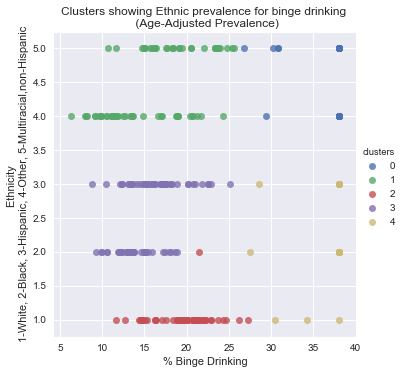

In [190]:
new_cdi = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi = new_cdi[new_cdi["DataValueType"] == 'Age-adjusted Prevalence']
new_cdi = new_cdi[new_cdi["StratificationCategory1"].str.contains('Race/Ethnicity')]
new_cdi = new_cdi[new_cdi["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi = new_cdi[['StratificationCategory1', 'DataValue', 'LocationDesc', 'Stratification1']].copy()

new_cdi = new_cdi.replace('White, non-Hispanic', 1)
new_cdi = new_cdi.replace('Black, non-Hispanic', 2)
new_cdi = new_cdi.replace('Hispanic', 3)
new_cdi = new_cdi.replace('Other, non-Hispanic', 4)
new_cdi = new_cdi.replace('Multiracial, non-Hispanic', 5)
new_cdi = new_cdi.replace(np.nan, 0)

pd.to_numeric(new_cdi['DataValue'])
pd.to_numeric(new_cdi['Stratification1'])
              
col = ['DataValue', 'Stratification1']
standardized = stats.zscore(new_cdi[col])

kmeans = KMeans(n_clusters=5, random_state=0).fit(standardized)
labels = kmeans.labels_

new_cdi['clusters'] = labels

col.extend(['clusters'])

print(new_cdi[col].groupby(['clusters']).mean())

sns.lmplot('DataValue', 'Stratification1',
          data=new_cdi,
          fit_reg=False,
          hue="clusters",)
plt.title('Clusters showing Ethnic prevalence for binge drinking \n (Age-Adjusted Prevalence)')
plt.xlabel('% Binge Drinking')
plt.ylabel('Ethnicity \n 1-White, 2-Black, 3-Hispanic, 4-Other, 5-Multiracial,non-Hispanic')

print( 'skewness: {}'.format( new_cdi.skew() ))
print( 'kurtosis: {}'.format( new_cdi.kurtosis() ))

In [191]:
new_cdi = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi = new_cdi[new_cdi["Stratification1"] == 'Overall']
new_cdi = new_cdi[new_cdi["DataValueType"] == 'Age-adjusted Prevalence']
new_cdi = new_cdi[new_cdi["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi = new_cdi[['LocationDesc', 'DataValue']].copy()
new_cdi = new_cdi.rename(columns={'LocationDesc':'States and Territories'})
new_cdi = new_cdi.sort_values(by=['DataValue'])

overall_alcohol_cdi = new_cdi.rename(columns={'DataValue': '% Overall Binge Drinkers (Age-Adjusted)'})
print( 'skewness: {}'.format( overall_alcohol_cdi.skew() ))
print( 'kurtosis: {}'.format( overall_alcohol_cdi.kurtosis() ))

skewness: % Overall Binge Drinkers (Age-Adjusted)    0.305435
dtype: float64
kurtosis: % Overall Binge Drinkers (Age-Adjusted)    0.216747
dtype: float64


In [192]:
df = lcd_df[lcd_df["Cause Name"].str.contains('Suicide')]
df = df.groupby('State').sum()
df = df.drop(['Year', 'Age-adjusted Death Rate'], axis=1)
df = df.drop(index='United States')
df = df.sort_values(by=['Deaths'])

suicide_lcd = df.rename(columns={'Deaths': 'Suicide Deaths'})
print( 'skewness: {}'.format( suicide_lcd.skew() ))
print( 'kurtosis: {}'.format( suicide_lcd.kurtosis() ))

skewness: Suicide Deaths    2.331058
dtype: float64
kurtosis: Suicide Deaths    6.634224
dtype: float64


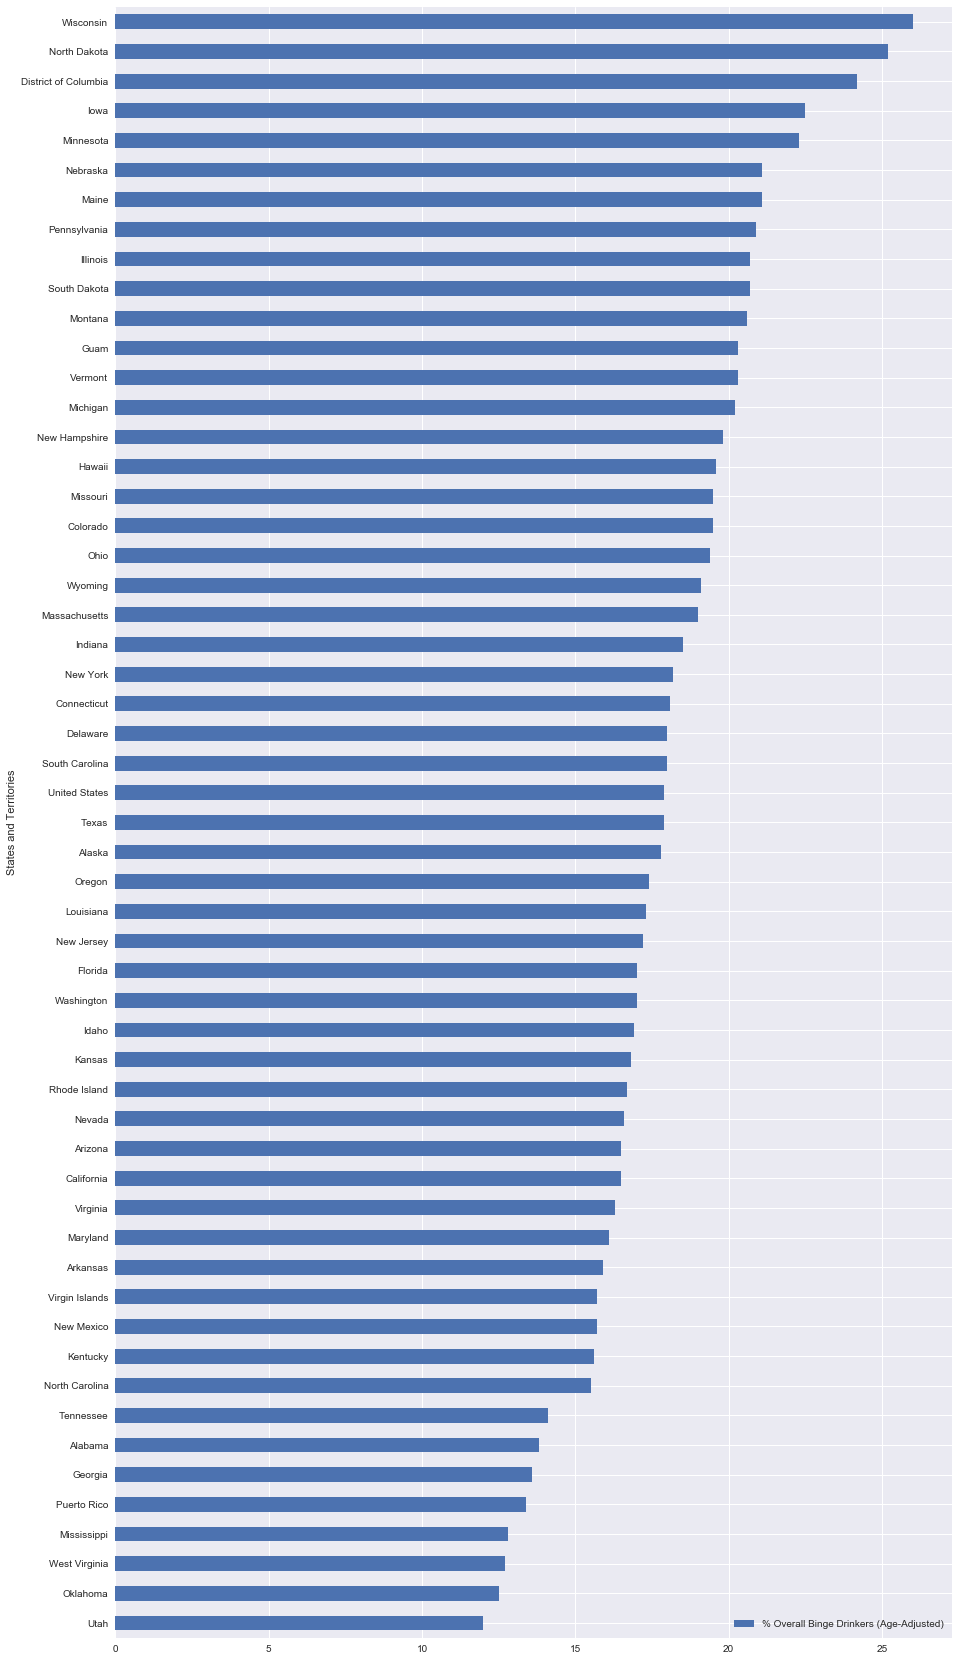

In [193]:
overall_alcohol_cdi.set_index('States and Territories').plot.barh(stacked=True,figsize=(15,30))

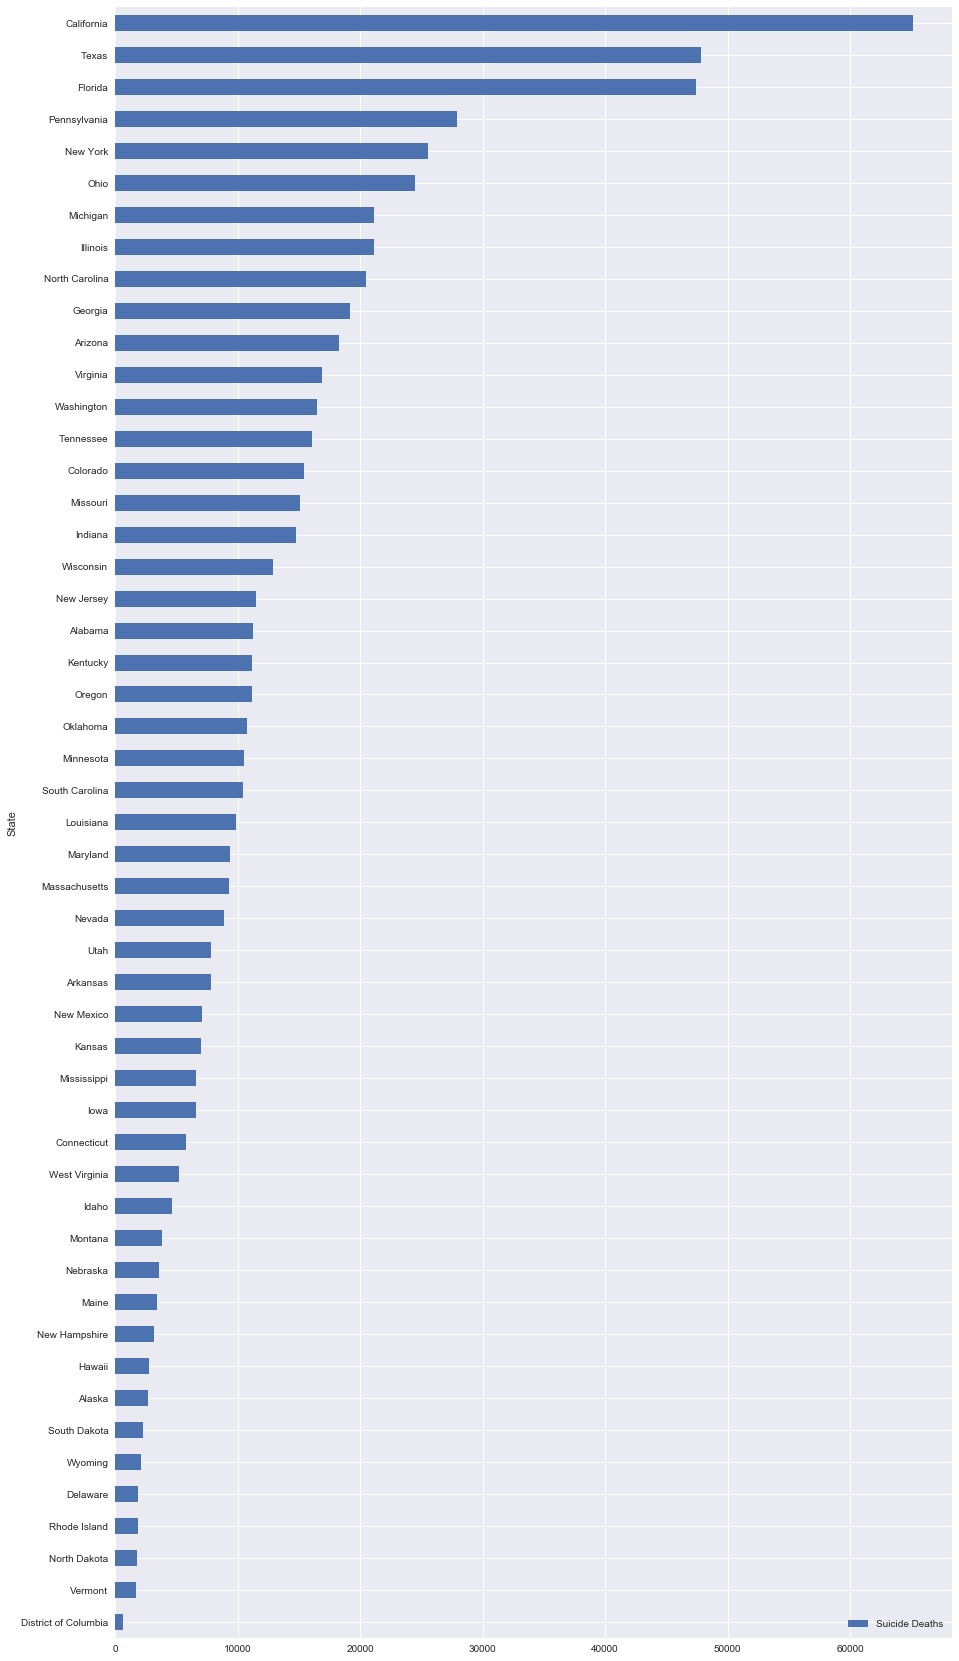

In [194]:
suicide_lcd.plot.barh(stacked=True,figsize=(15,30))